## Notebook 3: Mountain Ranges

In this notebook we will try to combine mountains into mountain ranges (and individual river basins into watersheds).

In prior notebooks we determined what the mountains are by looking at the highest paths in elevation.
However, that gives us loads of peaks, and its unfortunately hard to get meaning from that.

Rather, we can group mountains that seem to be part of the same generally mass, a mountain range.

In [1]:
## Import Statements
import numpy as np
import matplotlib.pyplot as plt
from src.map_image import *
from src.map_instance import *
from src.map_data import *
from src.map_transforms import *

%config InlineBackend.figure_format = 'retina'

# Parameters
params = {
    'dataset':'TBI',
    'region': 'hawaii',
    'minutes_per_node': 1,
    'image_folder': 'img/03/',
    'n_neighbors': 4,
    'flow_direction': 'up', # up = mountains or down = basins
}

# These provide a series of names so we can run the same code to compute both mountain ranges and water sheds
# Not all comments (especially early exploratory ones) will be corrected to the general names
def getLabels(params):
    params['direction_adjective'] = 'high' if params['flow_direction'] == 'up' else 'low'
    params['extremum_label'] = 'peak' if params['flow_direction'] == 'up' else 'sink'
    params['path_label'] = 'ridge' if params['flow_direction'] == 'up' else 'river'
    params['locale_label'] = 'mountain' if params['flow_direction'] == 'up' else 'basin'
    params['division_label'] = 'mountain_range' if params['flow_direction'] == 'up' else 'watershed'
    params['sealevel_division_label'] = 'island' if params['flow_direction'] == 'up' else 'drainage_basin'
    return params

params = getLabels(params)


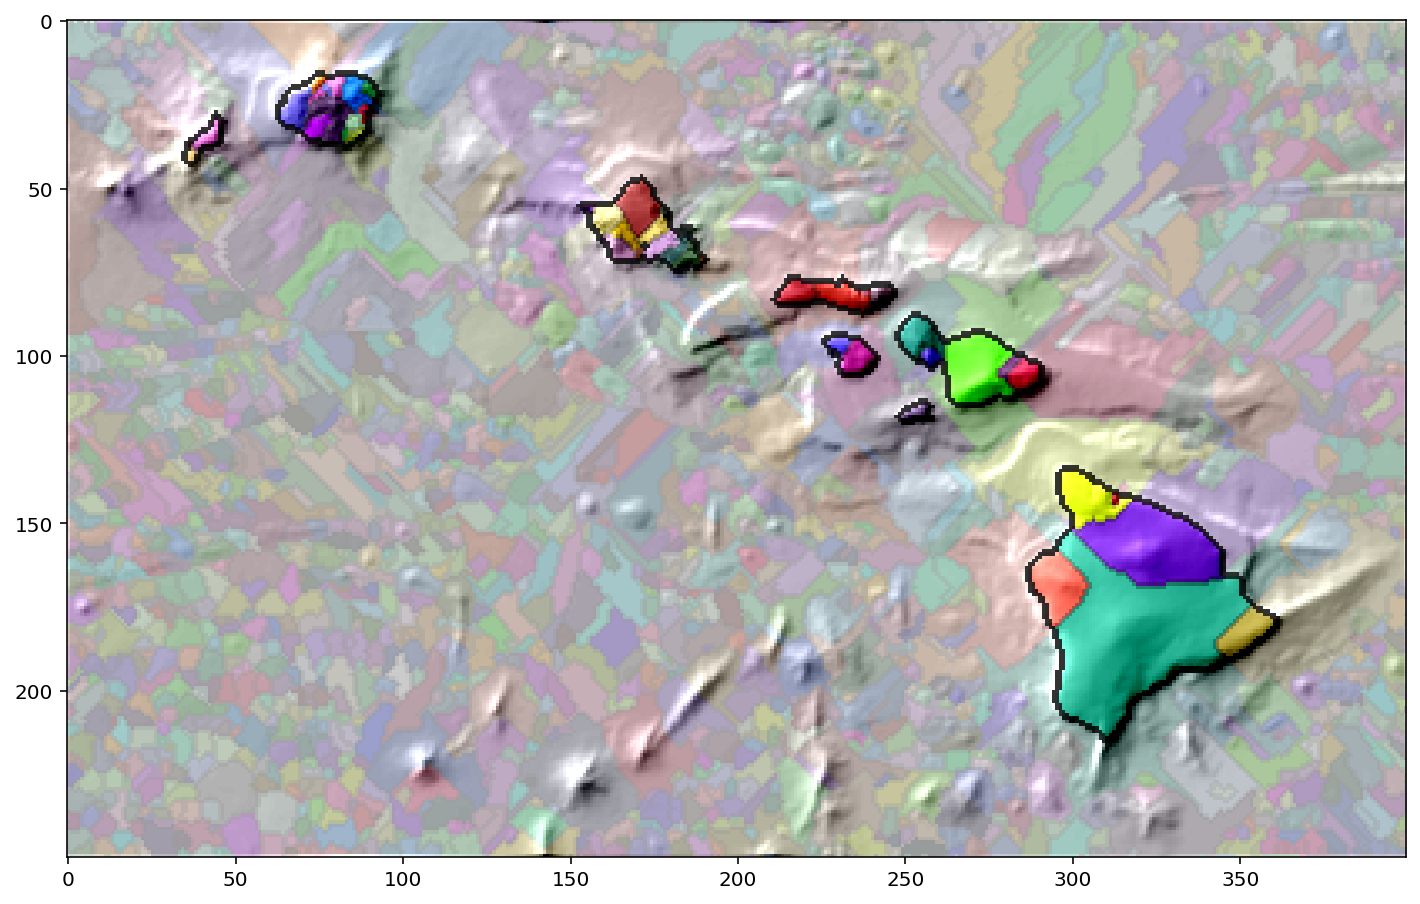

In [2]:
# Regenerate Elevation information and prepare many supporting maps
def getImageBase(maps, nodes_bg_value=None, nodes_bg_colormap='hashed', second_border=None):
    image = RasterImage(maps['elevation']) \
        .addLayer('base', 1) \
        .addLayer('locale_border', 0.7, nodes_selected=maps['locale_border'].getDataFlat())

    if nodes_bg_value is not None:
        transforms = ['norm']
        nodes_bg_value = nodes_bg_value.copy()
        if nodes_bg_colormap == 'hashed':
            # The values after 'norm' change based on the present maximum value 
            # This makes the hashed values for the same original value (eg. 12356) will be different
            # So we don't norm it will be more consistent
            transforms = []
            # Dividing by the number of nodes helps give us a better spread of colors after hashed
            nodes_bg_value = nodes_bg_value / len(nodes_bg_value)
        image = image.addLayer('node_background', nodes_bg_value,
                               colormap=nodes_bg_colormap, transforms=transforms, combine='multiply', opacity=0.5)

    if second_border is not None:
        image = image.addLayer('group_border', 0.5, nodes_selected=second_border, combine='multiply')

    return image.addLayer('sea', 1.2, nodes_selected=maps['sea'].getDataFlat(), combine='add', dissolve=.2) \
            .addLayer('hillshade', maps['hillshade'].getDataFlat(), combine='add', opacity=1, dissolve=1) \
            .addLayer('coast', 0.2, nodes_selected=maps['coast'].getDataFlat(), combine='multiply')

def generateBaseMaps(params, display_and_save_image=True):
    maps = {} # These should all be map instances
    maps['elevation'] = loadRegionMap(
        region=params['region'], 
        dataset=params['dataset'], 
        minutes_per_node=params['minutes_per_node'], 
        image_folder=params['image_folder'],
    )
    maps['hillshade'] = getHillshade(maps['elevation'], 1)
    maps['sea'] = maps['elevation'].newChildInstance(
        {'values': 'sea'},
        maps['elevation'].getDataFlat() < 0,
    )
    maps['coast'] = getBorder(maps['sea'], 1)
    if params['flow_direction'] == 'down':
        maps['elevation'] = maps['elevation'].newChildInstance(
            {'values': 'gravity'},
            -maps['elevation'].getDataFlat(),
        )
    params['n_nodes'] = maps['elevation'].getNumNodes()

    # Locales
    maps['highest_neighbor_index'] = getHighestNeighbor(maps['elevation'])
    maps['locale'] = getLocalPeaks(maps['highest_neighbor_index'])
    maps['locale_border'] = getBorder(maps['locale'], 1)

    # Display locales
    if display_and_save_image:
        getImageBase(maps, nodes_bg_value=maps['locale'].getDataFlat()) \
            .overrideLayerNames([params['locale_label'] + 's']) \
            .display().save().final()

    # Compute Neighbors / Adjacency List (useful for some algorithms)
    #
    # While some algorithms work well on linear arithmetic -- some are too hard to handle en masse
    # Rather, we can compute the adjacency list and utilize that in algorithms
    nodes_neighbors = getNodesNeighbors(
        maps['elevation'].getNumRows(),
        maps['elevation'].getNumCols(),
        params['n_neighbors'],
        wrap=False
    )

    return [maps, nodes_neighbors]

[maps, nodes_neighbors] = generateBaseMaps(params)

## Algorithm 1

In order to determine mountain ranges (or watersheds), we will iterate through the mountains themselves.
Starting at the lowest mountains -- find the border node to the highest other mountain and associate that.
This will build chains of mountains / mountain ranges (division).

From early investigation though, it does not appear quite right.
In the Hawaii map, if we stop the merging right before the last few peaks (20 left to go) we can see wide swatches of the ocean floor pointing to unexpected places.
There's a ridge west of Hawaii that is part of the Kauai range and part that is in the Molokai range -- why the split?
I think going from the lowest mountain peak to the highest is causing this problem, making changes of low peaks by coincedence, not intention.

### Asymptotic Analysis

n = # of nodes
m = # of mountains (probably n^0.5 or logn, but depends on the data)
r = # of nodes in mountain range (starts n/m but eventually tends to n)
e = # of neighbors (basically constant since it's 4 or 8, does not scale w/ map size

While there certainly are optimizations done by numpy, let's first estimate the efficiency assuming all array lookups and all transforms on arrays cost the size of the array.

* sort peaks O(m * logm)
* for each mountain, O(m)
  * find nodes in mountain range O(n)
  * for each node in mountain range O(r)
     * for neighbors of this node O(e) -- basically O(1)
        * lookup values, mnt ranges... O(1)
  * assign nodes in this mountain range to the taller one O(r)
  
Thereby, it looks like O(m*logm + m*r*e), which worst case maxes out at O(n^2), surprisingly not bad.
We could potentially speed it up by decreasing work in the loop for the mountain range -- if we keep track of what nodes are border nodes versus inner nodes (and thereby don't need to be checked) -- but it would only save the neighbor checks.

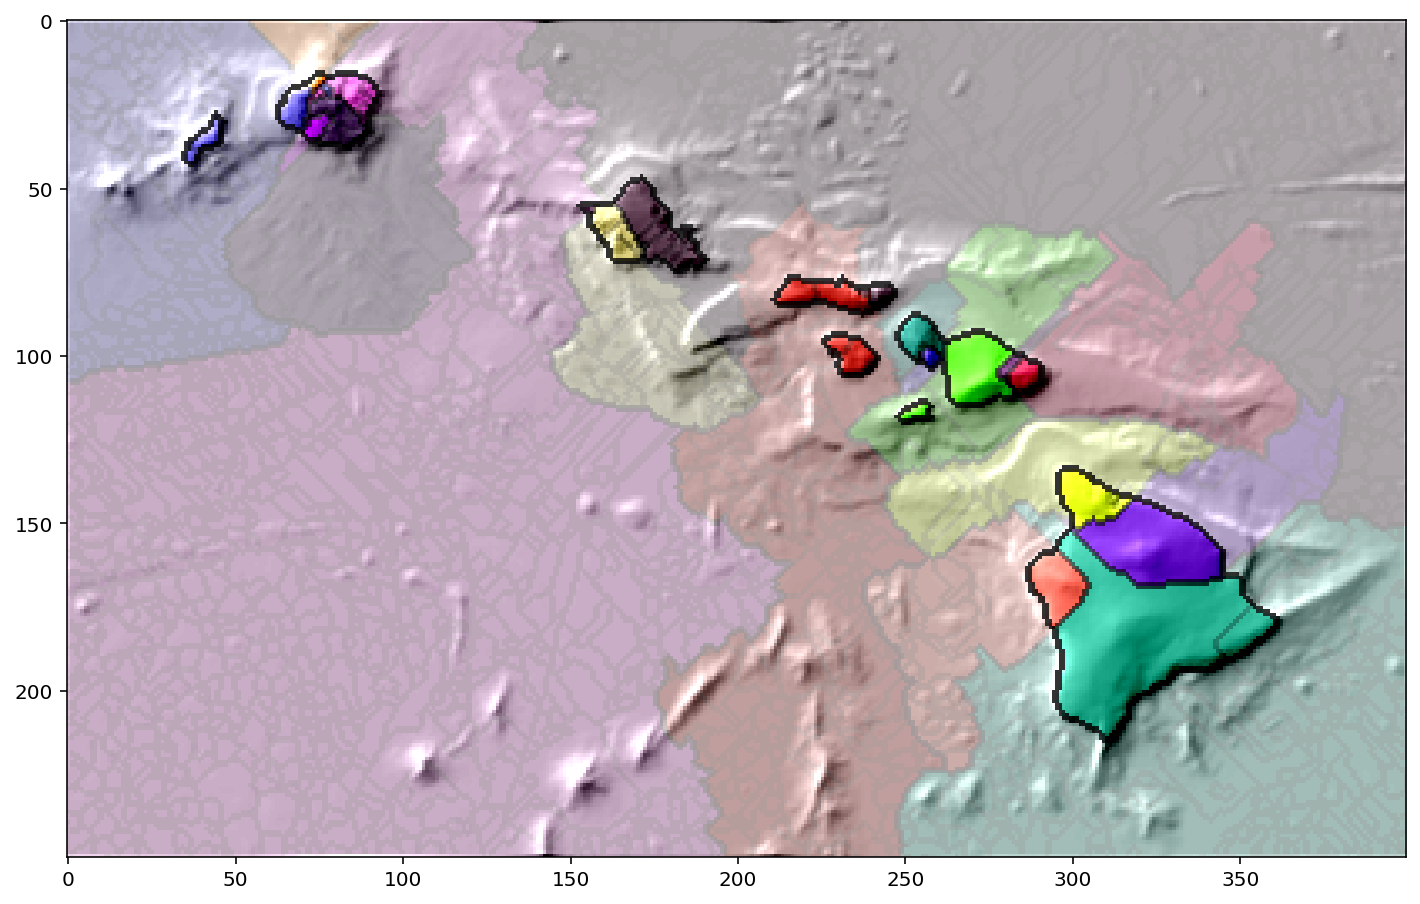

In [3]:
# in order to combine mountains into mountain ranges
# let's find the border of the mountain
# find the highest point outside of that border, and consider that the output of the mountain

def computeDivisionsAlgo1(params, maps, nodes_neighbors, draw=True):
    peaks_index = np.unique(maps['locale'].getDataFlat())
    peaks_division = np.full(params['n_nodes'], -1)
    peaks_ridge_node_in = np.full(params['n_nodes'], -1)
    peaks_ridge_node_out = np.full(params['n_nodes'], -1)

    nodes_division = maps['locale'].getDataFlat()

    nodes_value = maps['elevation'].getDataFlat()
    peaks_value = nodes_value[peaks_index]
    i_sorted_peaks = np.argsort(peaks_value)

    for i_peak in i_sorted_peaks[:-20]:
        peak_index = peaks_index[i_peak]
        division_nodes = np.array(np.where(nodes_division == peak_index)).flatten()

        # Search for the highest node outside of the mountain and consider that edge the "ridge"
        mountain_index = peak_index
        ridge_node_in = -1
        ridge_node_in_value = -1e6
        ridge_node_out = -1
        ridge_node_out_value = -1e6

        for mountain_node_index in division_nodes:
            mountain_node_value = nodes_value[mountain_node_index]
            for neighbor_index in nodes_neighbors[mountain_node_index,:]:
                # Exclude not wrapping neighbors and neighbors that are already in the same mountain
                if (neighbor_index == -1 or nodes_division[neighbor_index] == mountain_index):
                    continue

                # If the neighboring node is the highest neighbor found so far and the mountain node value is the highest
                # Consider it the best possible ridge candidate
                neighbor_value = nodes_value[mountain_node_value]
                if (neighbor_value > ridge_node_out_value and mountain_node_value > ridge_node_in_value):
                    ridge_node_in = mountain_node_index
                    ridge_node_in_value = mountain_node_value
                    ridge_node_out = neighbor_index
                    ridge_node_out_value = neighbor_value

        # Mark this as the ridge out and mark this other peak as the parent peak
        division = nodes_division[ridge_node_out]
        peaks_division[i_peak] = division
        peaks_ridge_node_in[i_peak] = ridge_node_in
        peaks_ridge_node_out[i_peak] = ridge_node_out

        nodes_division[division_nodes] = division


    # Draw the map
    if draw:
        map_division = maps['locale'].newChildInstance({'values': 'divisions'}, nodes_division)
        map_division_border = getBorder(map_division, 1)

        getImageBase(maps, 
               nodes_bg_value=map_division.getDataFlat(),
               second_border=map_division_border.getDataFlat()) \
           .overrideLayerNames([
               params['division_label'],
               'algo1',
               'holdout_20_merges'
           ]).display().save().final()
    
computeDivisionsAlgo1(params, maps, nodes_neighbors)


## Algorithm 2

This tries a different algorithm instead -- instead we iterate over every node.
I'm not a fan of going over every node (doing it per locale is better) -- but we had to go over every node in the prior algorithm anyway so perhaps this is more efficient.

The idea is that we are reconstructing the locales from the high values to the lower ones -- which should keep ridges w/ small gaps together better than before.


### Asymptotic Analysis

n = # of nodes
l = # of locales (probably n^0.5 or logn, but depends on the data)
r = # of nodes in division (starts n/l but eventually tends to n)

* sort all nodes O(n * logn)
* for all nodes O(n)
   * for all neighbors O(e)
      * lookups, comparisons, and assignment
      * merge two regions O(r) -> O(n)

Thereby, this algorithm has at most a O(n * n * e) runtime -- but since we only expect to have l merges and e is effectively constant, it's closer to O(n * l)


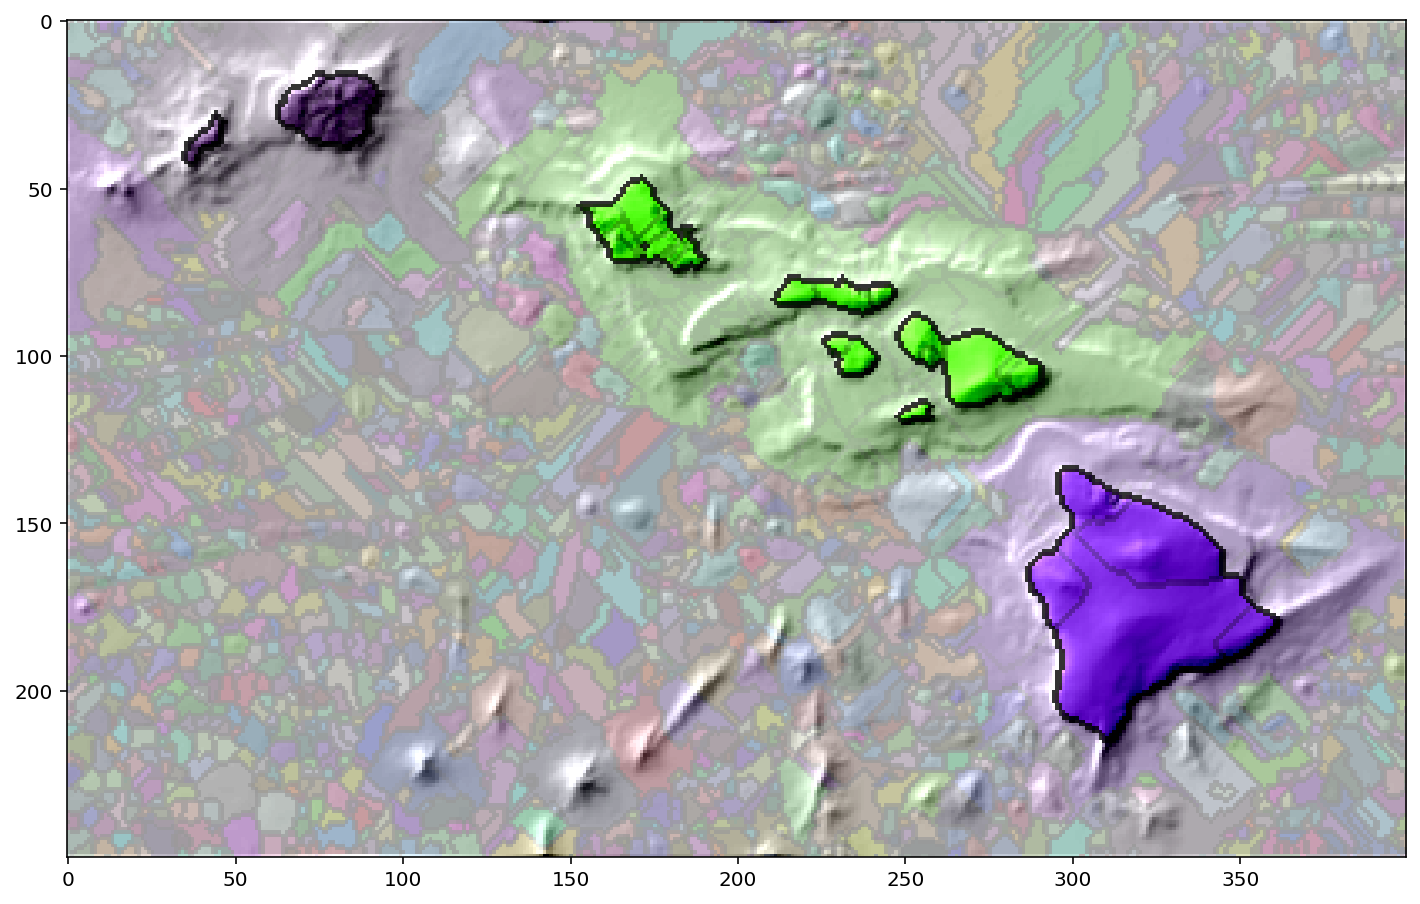

In [4]:
# Hmmm, that combined map does not look right
# Instead of going by peaks, we should go by nodes

def getDivisionMergePoints(params, maps, nodes_neighbors, draw_and_save_image=True):
    nodes_locale = maps['locale'].getDataFlat()
    nodes_division = nodes_locale.copy()
    
    # output data
    merges = []
    nodes_division_snapshot = np.zeros(params['n_nodes'], dtype=int)
    nodes_peak_division_parent = np.zeros(params['n_nodes'], dtype=int) - 1 # not necessarily used
    
    def mergeTwoRanges(lo_index, hi_index):
        locale_lo = nodes_locale[lo_index]
        locale_hi = nodes_locale[hi_index]
        division_lo = nodes_division[lo_index]
        division_hi = nodes_division[hi_index]
        nodes_division[nodes_division == division_lo] = division_hi
        nodes_peak_division_parent[division_lo] = division_hi
        
        return {
            'bridge_lo_index': lo_index,
            'bridge_lo_value': nodes_value[lo_index],
            'bridge_hi_index': hi_index,
            'bridge_hi_value': nodes_value[hi_index],
            'locale_lo': locale_lo,
            'locale_hi': locale_hi,
            'division_lo': division_lo,
            'division_hi': division_hi,
            'landsea_local_interface': # Values are the high-side mountain, the bridge, then the low-side mountain
                ('L' if nodes_value[locale_hi] > 0 else 'S') + 
                ('L' if nodes_value[hi_index] > 0 else 'S') + 
                ('L' if nodes_value[locale_lo] > 0 else 'S'),
            'landsea_division_interface': # Values are the high mountain range, the bridge, then the low mountain range
                ('L' if nodes_value[division_hi] > 0 else 'S') + 
                ('L' if nodes_value[hi_index] > 0 else 'S') + 
                ('L' if nodes_value[division_lo] > 0 else 'S'),
            'distance_between_bridge_and_hi_local_extremum':
                max(nodes_value[locale_hi], nodes_value[locale_lo]) - nodes_value[hi_index],
            'distance_between_bridge_and_hi_division_extremum': nodes_value[division_hi] - nodes_value[hi_index],
        }
        
    nodes_value = maps['elevation'].getDataFlat()
    nodes_index_hi_to_lo = np.argsort(-nodes_value);
    for i_explorer in np.arange(params['n_nodes']):
        explorer_index = nodes_index_hi_to_lo[i_explorer]
        node_value = nodes_value[explorer_index]
        explorer_division = nodes_division[explorer_index]

        if i_explorer == (params['n_nodes'] // 8):
            nodes_division_snapshot = nodes_division.copy()

        for neighbor_index in nodes_neighbors[explorer_index,:]:
            # Exclude not wrapping neighbors and neighbors that are already in the same mountain range
            if (neighbor_index == -1 or nodes_division[neighbor_index] == explorer_division):
                continue

            # They are different!
            neighbor_division = nodes_division[neighbor_index]

            if (nodes_value[explorer_division] > nodes_value[neighbor_division]):
                # The node's mountain range is taller, merge into that
                mergePoint = mergeTwoRanges(neighbor_index, explorer_index)
            else:
                # The neighbor's mountain peak is taller, merge into that
                mergePoint = mergeTwoRanges(explorer_index, neighbor_index)
                
                # Update the explorers mountain range
                explorer_division = neighbor_division
            merges.append(mergePoint)
            
            
    # Draw the map
    if draw_and_save_image:
        map_division = maps['locale'].newChildInstance({'values': 'parent_extremum'}, nodes_division_snapshot)
        map_division_border = getBorder(map_division, 1)

        getImageBase(maps, 
               nodes_bg_value=map_division.getDataFlat(),
               second_border=map_division_border.getDataFlat()) \
           .overrideLayerNames([
               params['division_label'],
               'algo2',
               'snapshot_at_oneeighthdone'
           ]).display().save().final()
    
    return merges
    
merges = getDivisionMergePoints(params, maps, nodes_neighbors)


In [5]:
# Some descriptive statistics
def printEarlyDivisionStats(params, merges, nodes_locale): 
    print('How many things do we have?')
    print('{:10d} nodes (pixel), points across the map along a 2-dimensional grid'.format(len(nodes_locale)))
    print('{:10d} {locale:s}s, groupings where all of the nodes in a local area point {direction:s}ward to a single point'.format(
        len(np.unique(nodes_locale)), locale=params['locale_label'], direction=params['flow_direction']))
    print('{:14s} {extremum:s}s are the {direction_adj:s}est point in these {locale:s}s and are used to index them'.format(
        '', extremum=params['extremum_label'], locale=params['locale_label'], direction_adj=params['direction_adjective']))
    print('{:10d} merges, times where two {:s}s are combined, based on the {direction_adj:s}est point outward from a {:s}'.format(
        len(merges), params['locale_label'], params['locale_label'], direction_adj=params['direction_adjective']))
    print('{:14s} bridges or saddles are the name for the specific points where the merge happens'.format(''))
    print('{:14s} {path:s}s are the paths connecting bridges to their {extremum:s} -- following the {direction_adj:s}est local nodes'.format(
        '', path=params['path_label'], extremum=params['extremum_label'], direction_adj=params['direction_adjective']))

    print('')
    print('Let\'s now think of how {locale:s}s intersect and are combined along the bridge nodes'.format(locale=params['locale_label']))
    print('Think of the intersections like V shapes. greater {extremum:s} -> bridge -> lesser {extremum:s} -- are these Vs large? Are they partially underwater?'.format(
        extremum=params['extremum_label']))
    
    print('')
    print('Do the {path:s}s in the connections cross the water line / interface? Considering what is above water (L) or below (S)?'.format(path=params['path_label']))
    landsea_local_interfaces = np.array([x['landsea_local_interface'] for x in merges])
    landsea_division_interfaces = np.array([x['landsea_division_interface'] for x in merges])
    print('{:18s}: {:6s} {:6s}'.format('Interface Pattern','Local','Divisions'))
    for interface_pattern in sorted(np.unique(landsea_local_interfaces)):
        print('{:18s}: {:6d} {:6d}'.format(
            interface_pattern,
            np.sum(landsea_local_interfaces == interface_pattern),
            np.sum(landsea_division_interfaces == interface_pattern),
        ))
        
    print('')
    print('What\'s the distance between the bridge & the {extremum:s}?'.format(
        extremum=params['extremum_label']))
    print('    local = neighboring {locale:s}s, divisions = among the {division:s} it is connected to.'.format(
        locale=params['locale_label'], division=params['division_label']))
    log_base = 10 ** 0.5
    local_distances_logged_rounded = np.log(np.array([x['distance_between_bridge_and_hi_local_extremum'] for x in merges])+0.001) // np.log(log_base)
    range_distances_logged_rounded = np.log(np.array([x['distance_between_bridge_and_hi_division_extremum'] for x in merges])+0.001) // np.log(log_base)
    print('{:16s}: {:6s} {:6s}'.format('Distance','Local','Divisions'))
    for distance_group in sorted(np.unique(range_distances_logged_rounded)):
        group_min = int(np.exp(distance_group * np.log(log_base)))
        group_max = int(np.exp((distance_group + 1) * np.log(log_base)))
        print('{:6d} to {:6d}: {:6d} {:6d}'.format(
            group_min, group_max,
            np.sum(local_distances_logged_rounded == distance_group),
            np.sum(range_distances_logged_rounded == distance_group),
        ))
    
printEarlyDivisionStats(params, merges, maps['locale'].getDataFlat())

How many things do we have?
    100000 nodes (pixel), points across the map along a 2-dimensional grid
      2337 mountains, groupings where all of the nodes in a local area point upward to a single point
               peaks are the highest point in these mountains and are used to index them
      2336 merges, times where two mountains are combined, based on the highest point outward from a mountain
               bridges or saddles are the name for the specific points where the merge happens
               ridges are the paths connecting bridges to their peak -- following the highest local nodes

Let's now think of how mountains intersect and are combined along the bridge nodes
Think of the intersections like V shapes. greater peak -> bridge -> lesser peak -- are these Vs large? Are they partially underwater?

Do the ridges in the connections cross the water line / interface? Considering what is above water (L) or below (S)?
Interface Pattern : Local  Divisions
LLL               :   

# Paths: Ridgelines and Rivers

In this next group of images and algorithms, lets visualize the paths as these divisions are combined together.

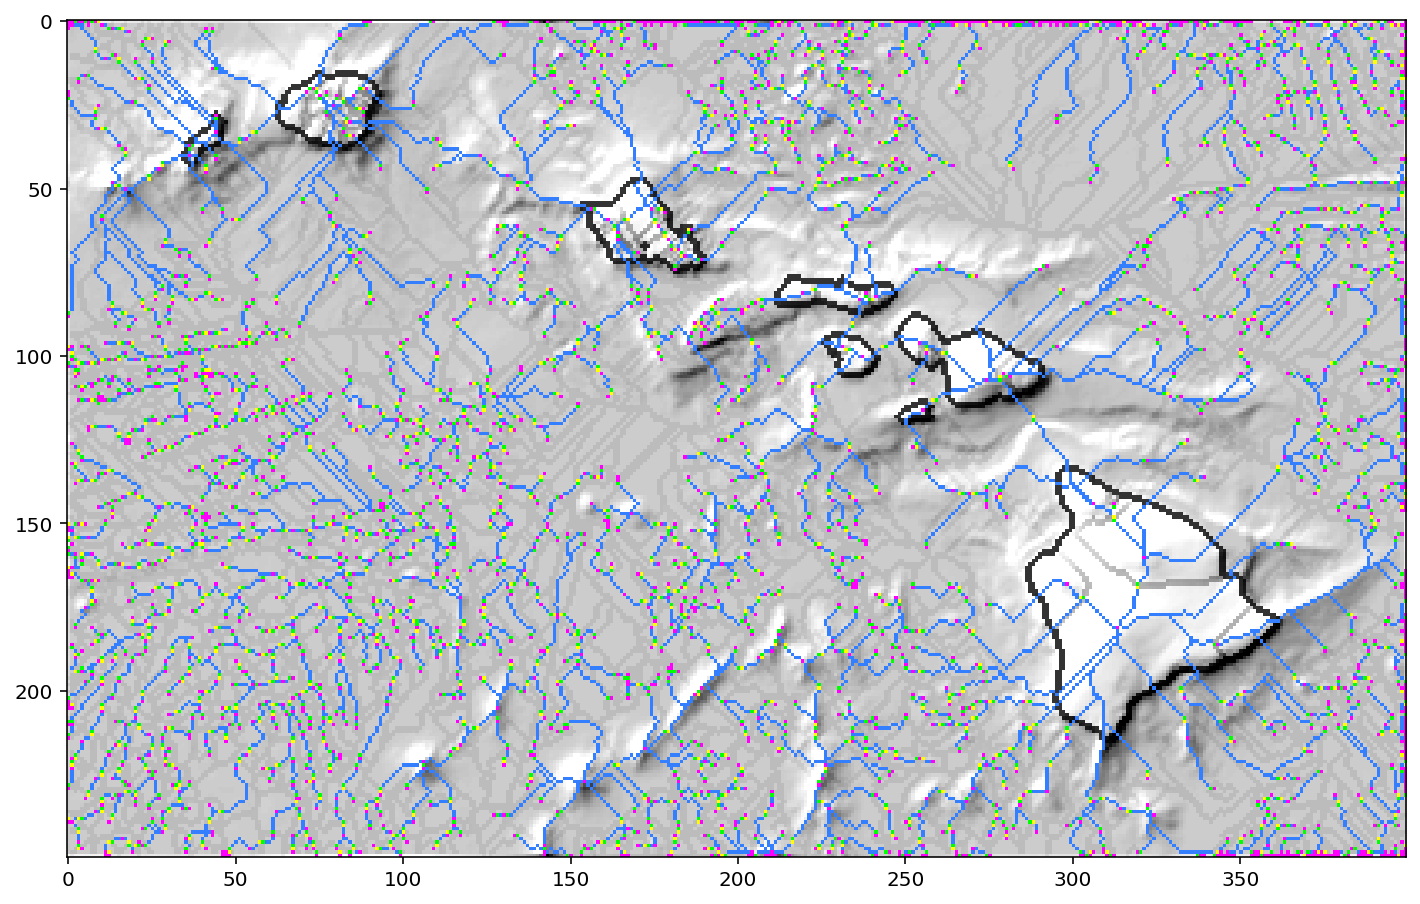

In [6]:
### Draw the paths between extremums
# We can look at all of the merge points and draw paths
# up to the peaks on either side -- this is the tallest path connecting 
# the two mountains

def getPaths(params, maps, merges, draw=False):
    HAS_NO_HIGHER_NEIGHBOR = -1 # constant when we are at a local maximum
    nodes_highest_neighbor_index = maps['highest_neighbor_index'].getDataFlat()
    nodes_path = np.zeros(params['n_nodes'], dtype=bool)
    nodes_lo_bridge = np.zeros(params['n_nodes'], dtype=bool)
    nodes_hi_bridge = np.zeros(params['n_nodes'], dtype=bool)

    for i_merge in np.arange(len(merges)):
        merge = merges[i_merge]
        bridge_lo_index = merge['bridge_lo_index']
        bridge_hi_index = merge['bridge_hi_index']
        nodes_lo_bridge[bridge_lo_index] = True
        nodes_hi_bridge[bridge_hi_index] = True

        # Follow the nodes upward from the bridge on both sides, marking those as ridge nodes
        cur_node = bridge_lo_index
        while cur_node != HAS_NO_HIGHER_NEIGHBOR:
            nodes_path[cur_node] = True
            cur_node = nodes_highest_neighbor_index[cur_node]
        cur_node = bridge_hi_index
        while cur_node != HAS_NO_HIGHER_NEIGHBOR:
            nodes_path[cur_node] = True
            cur_node = nodes_highest_neighbor_index[cur_node]
            
    # Draw the map
    if draw:
        getImageBase(maps) \
            .addLayer('path', [0.2,0.5,1], nodes_selected=nodes_path, combine='set') \
            .addLayer('lo_bridge', [1, 1, 0], nodes_selected=nodes_lo_bridge, combine='set') \
            .addLayer('hi_bridge', [0, 1, 0], nodes_selected=nodes_hi_bridge, combine='set') \
            .addLayer('extremum', [1, 0, 1], nodes_selected=(nodes_highest_neighbor_index == HAS_NO_HIGHER_NEIGHBOR), combine='set') \
            .overrideLayerNames([
                params['division_label'],
                'algo2',
                params['path_label']+'s1'
            ]).display().final()
    
    return nodes_path

nodes_path = getPaths(params, maps, merges, draw=True)
    

### Path visualization Analysis
The paths as-is are interesting but we don't have a great way to compare the importance of them. For instance, all of the seafloor paths show interesting patterns but are mostly noise -- they don't matter. Where multiple paths come together or they connect large areas -- that's really important.

Perhaps we can change the significance of the rivers/ridges by the power, some ideas:
* Color by elevation
* Color by how much mass is passed through the river. What does mass mean?
  * The number of nodes that flow into this node?
  * The total value flowing

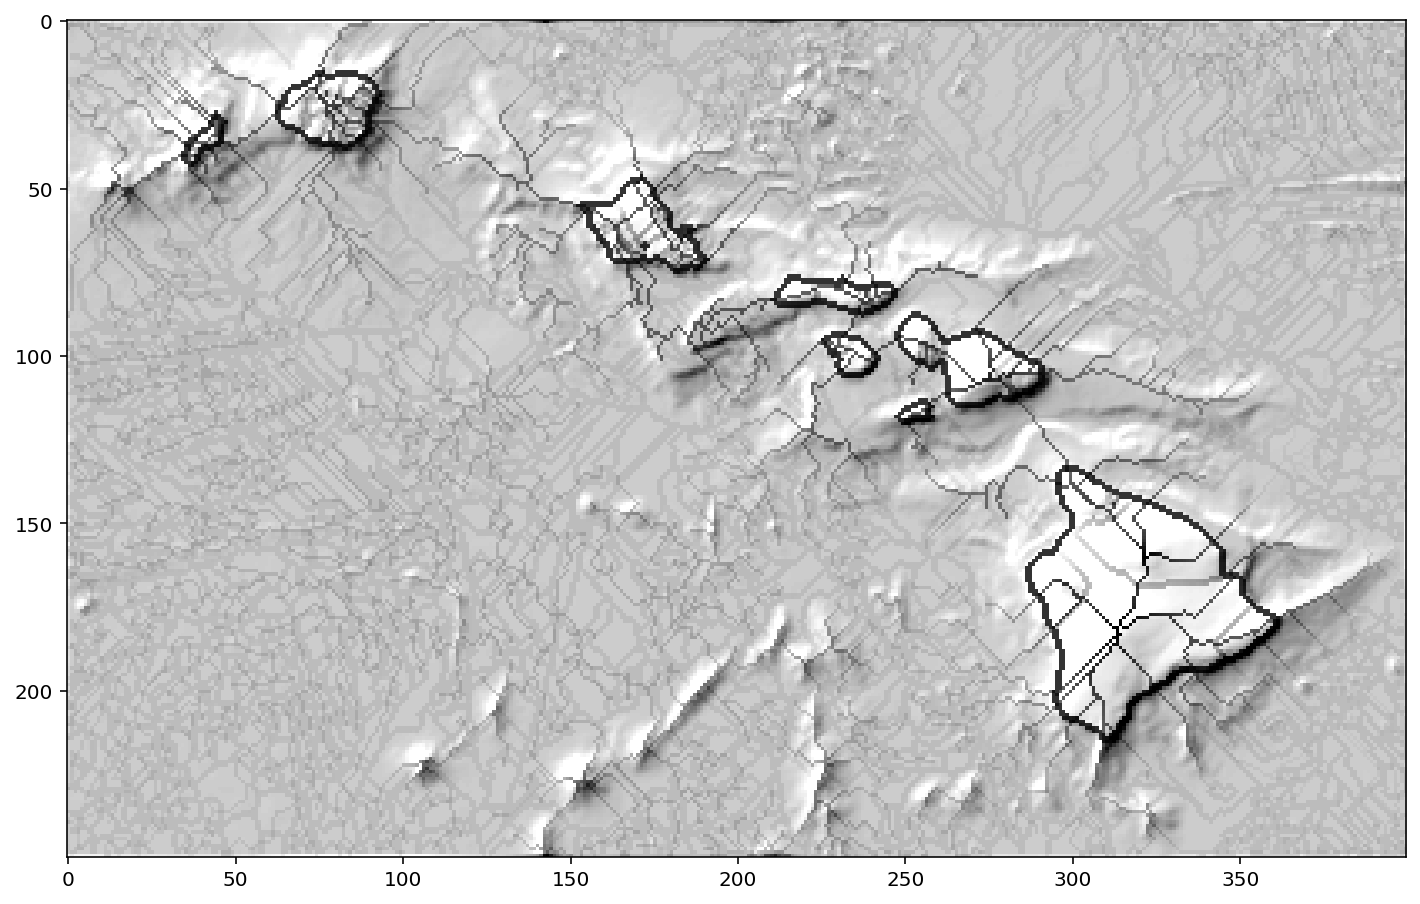

In [7]:
# Show paths by their elevation

# Draw the map
getImageBase(maps) \
    .addLayer('path', -maps['elevation'].getDataFlat(), nodes_selected=nodes_path, transforms='norm', combine='multiply') \
    .overrideLayerNames([
        params['division_label'],
        'algo2',
        params['path_label']+'s2'
    ]).display().final()

### Computing the global path graph
In order to do this, we may need to compute the "taller node" values but in a way that connects all to the highest peak. Right now all taller nodes point to the local peak -- but what if we change the direction of flow along the ridges that connect them so that Peak A flows into Peak B insted of being a terminal itself.

This is easy for two adjacent peaks -- but we will have a longer path to combine as we merge more. We can compute this by looking at the merge sites and work updates -- look at the lowest elevation merge, change the river of the lower peak to point to the higher peak, then repeat for all merge sites, using the updated "taller" graph.

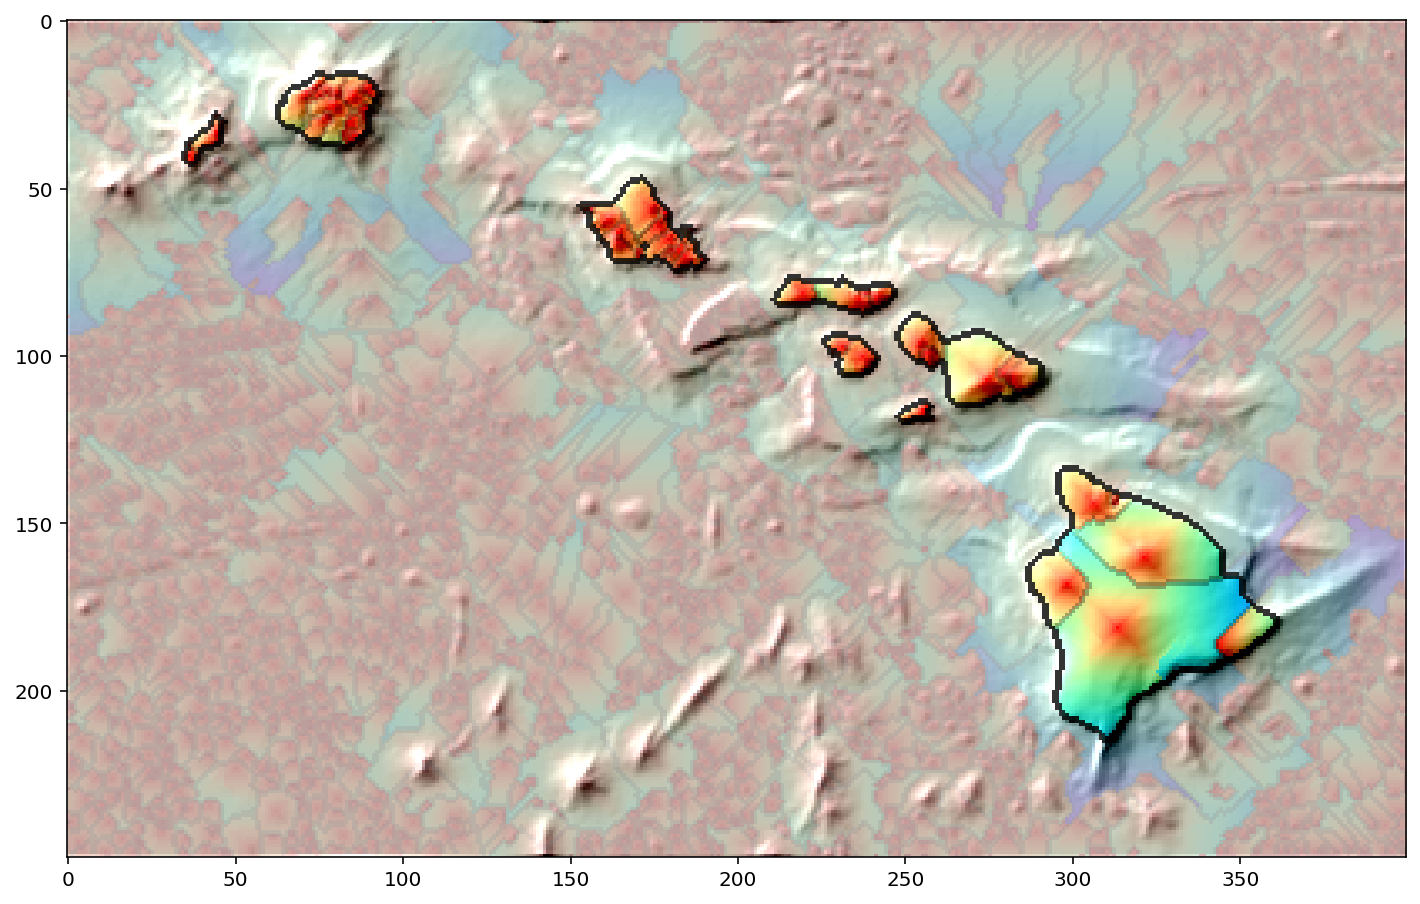

In [8]:
# Let's get a sense for the pattern of paths coming together by working backwards from the tallest

def renderPathDistanceFromLocalExtremum(params, maps):
    nodes_value = maps['elevation'].getDataFlat()
    nodes_highest_neighbor_index = maps['highest_neighbor_index'].getDataFlat()
    nodes_distance_from_local_extremum = np.zeros(params['n_nodes'], dtype=int) - 1

    # start from the globally tallest node and go down
    nodes_index_hi_to_lo = np.argsort(-nodes_value);
    for node_index in nodes_index_hi_to_lo:
        uphill_node_index = nodes_highest_neighbor_index[node_index]
        node_distance = 0 if uphill_node_index == -1 else nodes_distance_from_local_extremum[uphill_node_index]
        nodes_distance_from_local_extremum[node_index] = node_distance + 1

    # Draw the mountains by their distance from the peaks
    nodes_distance_normed = -np.sqrt(nodes_distance_from_local_extremum)
    getImageBase(maps, 
             nodes_bg_value=nodes_distance_normed, nodes_bg_colormap='rainbow') \
        .overrideLayerNames([
            params['division_label'],
            'algo2',
            'dist_from_'+params['extremum_label'],
        ]).display().save().final()
    
renderPathDistanceFromLocalExtremum(params, maps)

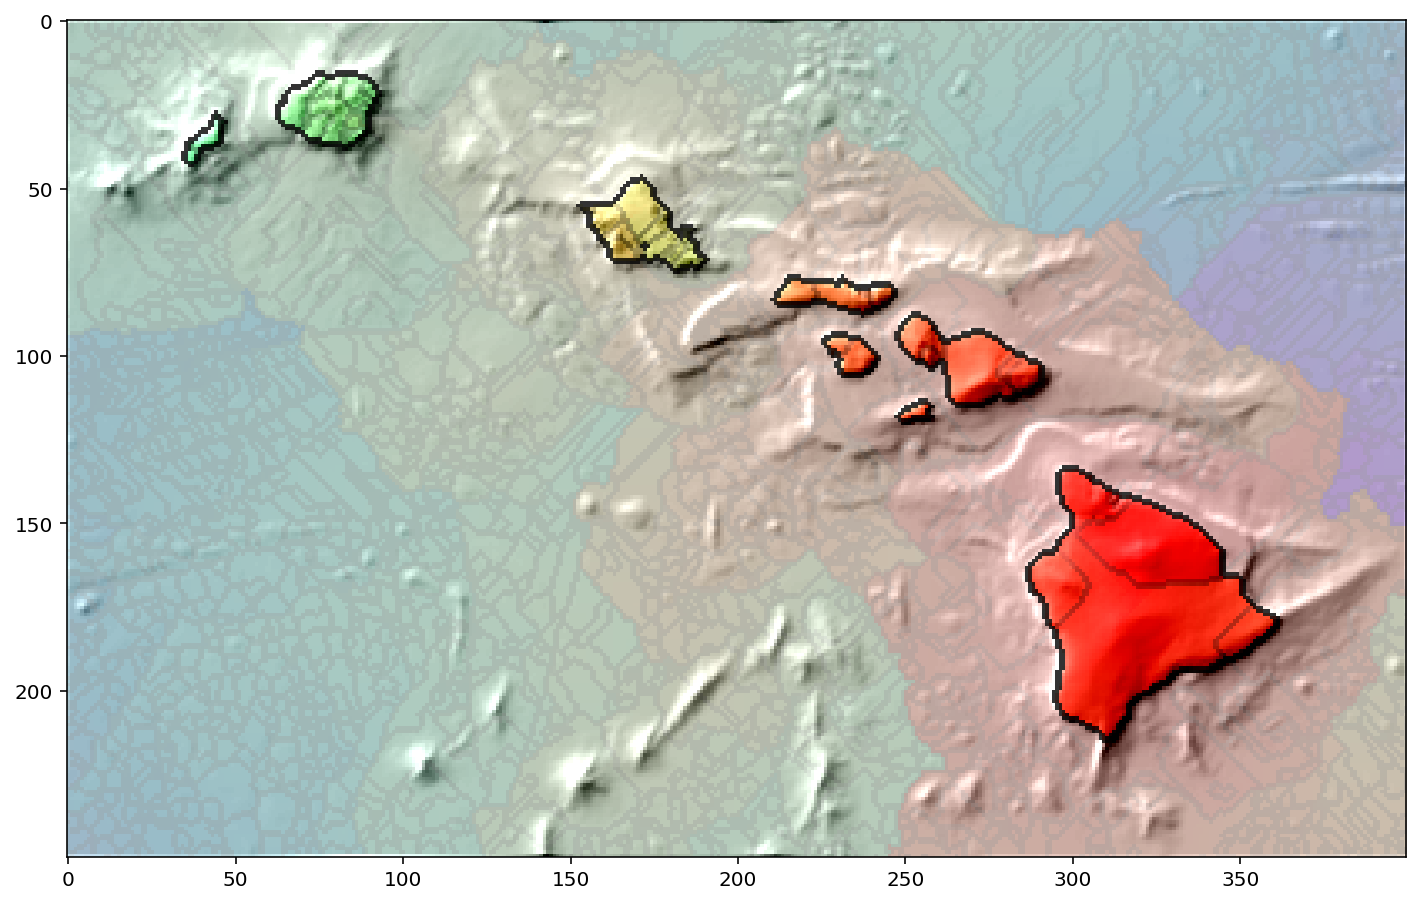

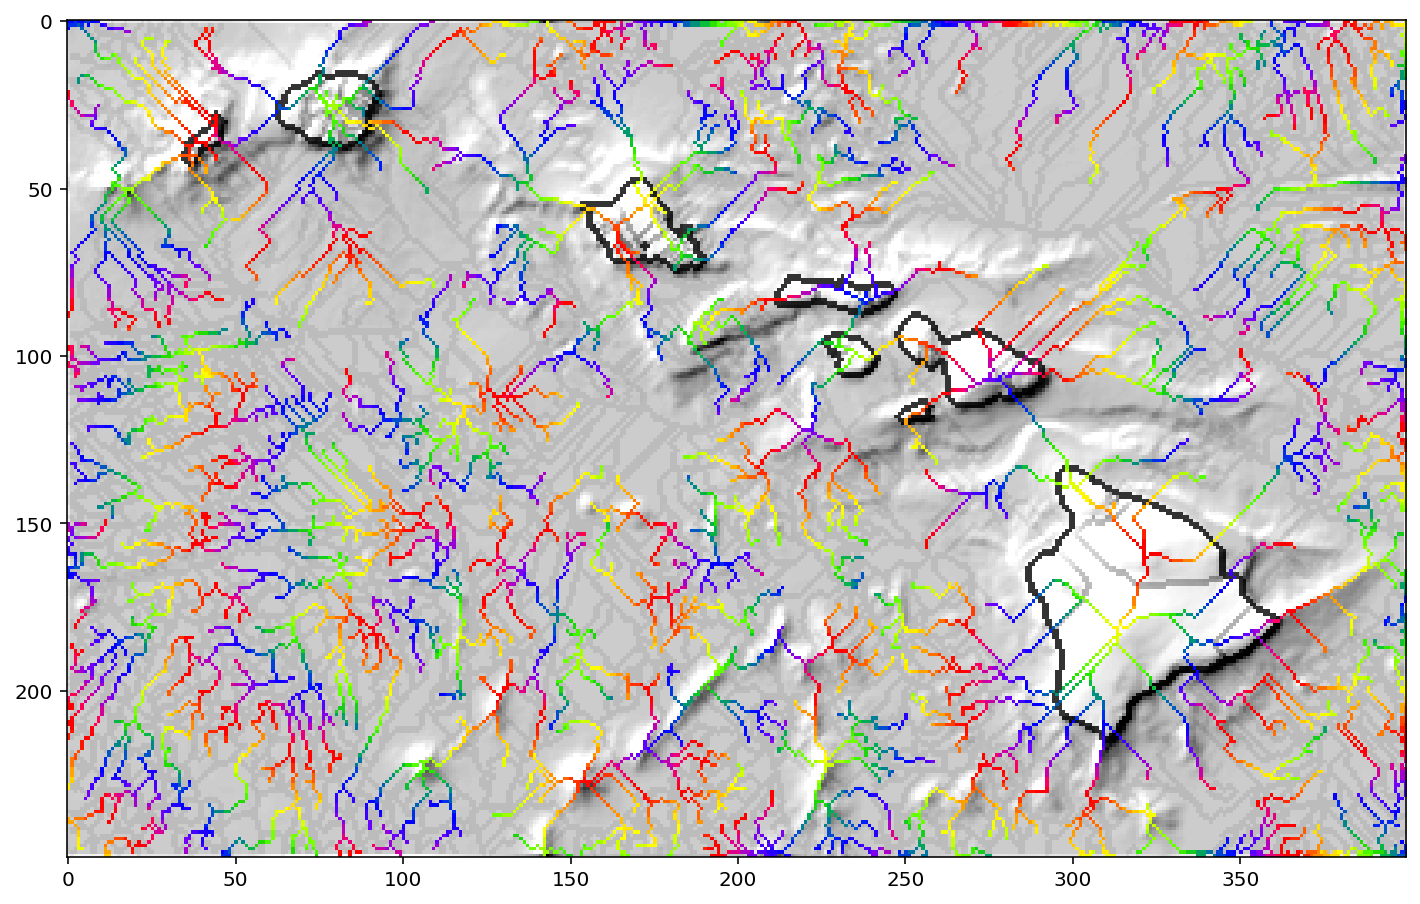

In [9]:
# Now lets compute the global paths
# Go through all merge lines

def drawGlobalPathParentGradient(params, maps, draw_path_map=False):

    nodes_global_path_parent = maps['highest_neighbor_index'].getDataFlat()

    for merge in reversed(merges):
        node_being_flipped = merge['bridge_lo_index']
        node_new_uphill = merge['bridge_hi_index']

        while node_being_flipped != -1:
            node_old_uphill = nodes_global_path_parent[node_being_flipped]
            nodes_global_path_parent[node_being_flipped] = node_new_uphill
            node_new_uphill = node_being_flipped
            node_being_flipped = node_old_uphill

    # Now we have a new river graph, let's redo the distance
    nodes_distance_from_global_extremum = np.zeros(params['n_nodes'], dtype=int)

    # This time we cannot go by the elevations because some low-elevation nodes may be "higher" in this new river graph
    # so we have to iterate through the 
    exploring_nodes = np.where(nodes_global_path_parent == -1)[0]

    for i_node in np.arange(params['n_nodes']):
        node_index = exploring_nodes[i_node]

        uphill_node_index = nodes_global_path_parent[node_index]
        node_distance = 0 if uphill_node_index == -1 else nodes_distance_from_global_extremum[uphill_node_index]
        nodes_distance_from_global_extremum[node_index] = node_distance + 1

        # Add next nodes to the queue
        exploring_nodes = np.append(exploring_nodes, np.where(nodes_global_path_parent == node_index)[0])

    # Draw the locales by their distance from the extremums
    nodes_global_distance_normed = -nodes_distance_from_global_extremum
    getImageBase(maps, 
             nodes_bg_value=nodes_global_distance_normed, nodes_bg_colormap='rainbow') \
        .overrideLayerNames([
            params['division_label'],
            'algo2',
            'dist_from_global_'+params['extremum_label']+'_along_'+params['path_label']+'s'
        ]).display().save().final()    
    
    if draw_path_map:
        getImageBase(maps) \
            .addLayer('path_dist_from_global_point', -nodes_global_distance_normed, colormap='prism', transforms=['norm'], nodes_selected=nodes_path, combine='set') \
            .overrideLayerNames([
                params['division_label'],
                'algo2',
                params['path_label']+'_dist_from_global_'+params['path_label']
            ]).display().save().final()
    
drawGlobalPathParentGradient(params, maps, draw_path_map=True)

## Distinguishing separate ranges: visualizing borders & splitting on merge points

I'm trying to capture 1) a better way to visualize the different regions but also 2) split the regions into sensible mountain ranges.

A good idea may be to focus on the 'merge' points -- where we connect two mountains to groups into ranges. Instead of allowing every merge -- we could block two mountains from merging, recognizing they are in different ranges. How do we decide this?
* Try to split things equally, 50% on one side, 50% on the other, and iterate
  * While this could work, it seems like it would be arbitrary
* Drop the "lowest" merge points
  * While this /could/ work, it would prevent us from combining the underwater mountain ranges that we visually can justify. 
  * This is what we already see by the visualizations above taking a snapshot @ 1/8th the way there.
* Only allow underwater merge points for underwater ranges and overland (aka subaerial) merge points for overland ranges -- this could make sense
* Distinguish "plains" or "plateaus" from the mountain ranges -- drop merge points in plains.
  * That's an interesting idea but will require us to define what a plain is, which sounds like a good followup but yet another way to define a region.
* Prevent merges when there's a big difference between the merge points & the peaks
  * eg. both peaks are really tall, but the merge point is far below it
  * Or the combined distance between the merge point & 2 peaks is differnt
  * I think this may work, but it looks like a threshold that would have to be calibrated -- also if we use this to split 2 regions, would that mean we split?
  * Another decision criteria here: do we mean the highest peak in the range or just the peak between the two merge points?

Another idea is to not focus on splitting merge points, but if we try every split, computing what the persistent borders are. For example, at every merge point compute the border between the ranges on either side -- and repeat this over and over and add up the borders that persist the most. On the Hawaii example I think this would distinguish the ocean plain from the main island groups.

There also is rationale to not over-focus on 1 merging point (since it could be many) and try to use graph algorithms with approximate cost functions, guessing ranges and converge on solutions. That sounds computationally difficult on this voxel approach but that may mirror human judgment and pattern matching better.

Anyway, for now, let's just try some of those un-merging ideas above

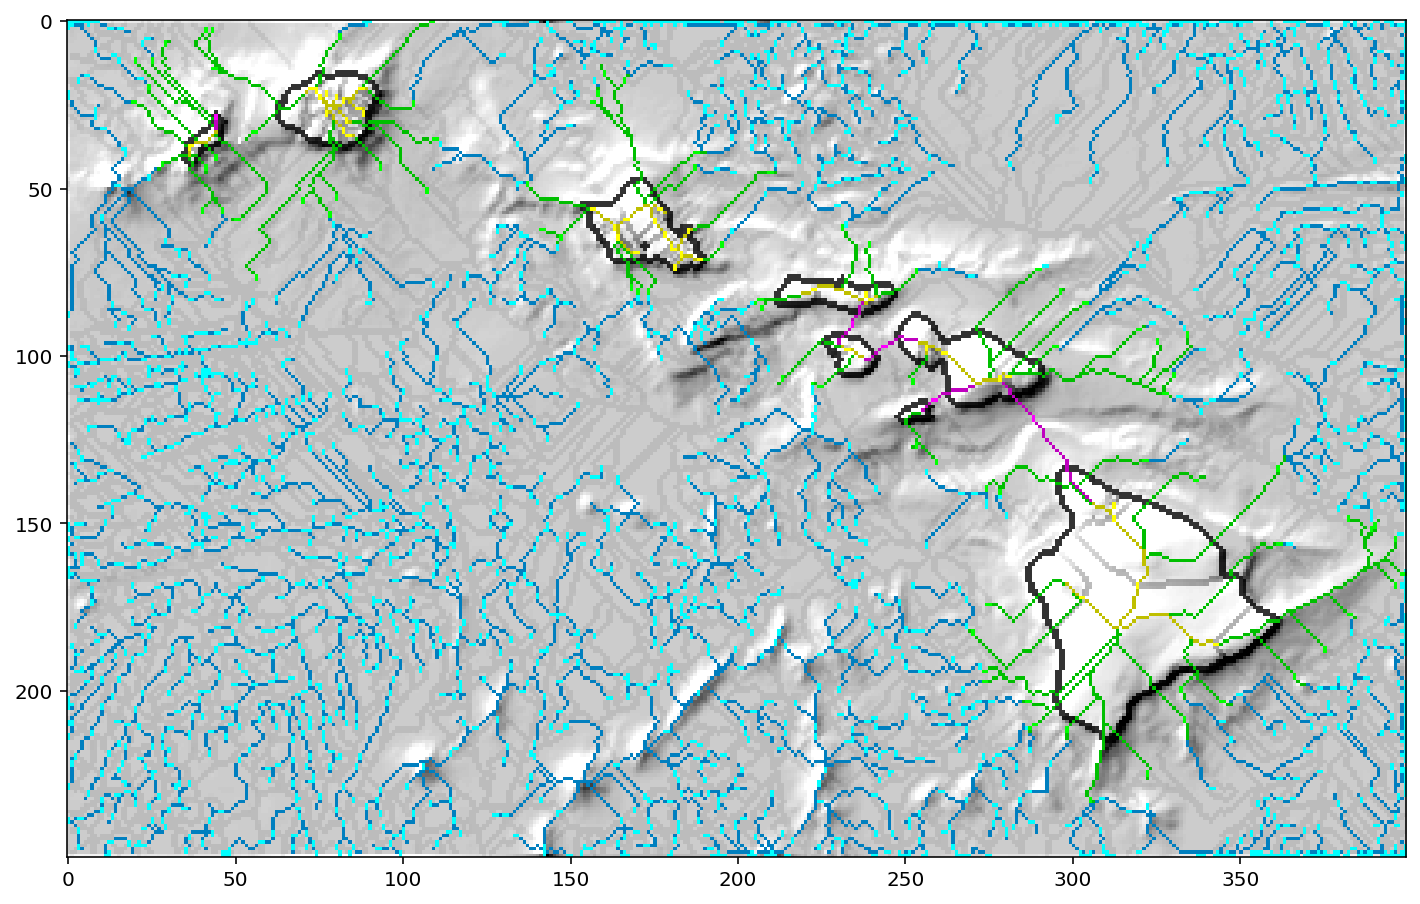

In [10]:
### Re-grouping #1
# Only allow underwater merge points for underwater ranges 
# and overland (aka subaerial) merge points for overland ranges

# Algorithm
# We want to iterate through X many merge points
#     X is all or maybe a fixed number, fraction of all merge points, or uses a threshold like the side on either side)
# For each of these merge points compute the mountains on either side using a BFS to find the connected components
#     Then split into 2 groups

# Visualize the different merge domain types
# We can use the same algorithm used to draw ridge lines

def getPathInterfaceType(params, maps, merges, display_image=False):
    nodes_highest_neighbor_index = maps['highest_neighbor_index'].getDataFlat()
    nodes_path_interface = np.full(params['n_nodes'], 'UNK')
    nodes_bridge = np.zeros(params['n_nodes'], dtype=bool)
    nodes_locale_merge_interface = np.full(params['n_nodes'], 'UNK')
    nodes_value = maps['elevation'].getDataFlat()

    for merge in merges:
        node_lo = merge['bridge_lo_index']
        node_hi = merge['bridge_hi_index']
        merge_interface = merge['landsea_local_interface']

        nodes_bridge[node_lo] = True
        nodes_bridge[node_hi] = True

        # Determine the type of paths from both merge points to their local extremum
        cur_node = node_lo
        while cur_node != -1:
            nodes_path_interface[cur_node] = min(merge_interface, nodes_path_interface[cur_node])
            nodes_locale_merge_interface[cur_node] = min(merge_interface, nodes_locale_merge_interface[cur_node])
            cur_node = nodes_highest_neighbor_index[cur_node]
        cur_node = node_hi
        while cur_node != -1:
            nodes_path_interface[cur_node] = min(merge_interface, nodes_path_interface[cur_node])
            cur_node = nodes_highest_neighbor_index[cur_node]

    # Draw the map
    if display_image:
        getImageBase(maps) \
            .addLayer('ridge_merged_LLL', [.75, .75,   0], nodes_selected=(nodes_path_interface == 'LLL'), combine='set') \
            .addLayer('ridge_merged_SSS', [  0,  .5, .75], nodes_selected=(nodes_path_interface == 'SSS'), combine='set') \
            .addLayer('ridge_merged_LSS', [  0, .75,   0], nodes_selected=(nodes_path_interface == 'LSS'), combine='set') \
            .addLayer('ridge_merged_LSL', [.75,   0, .75], nodes_selected=(nodes_path_interface == 'LSL'), combine='set') \
            .addLayer('ridge_merged_LLS', [.75,   0,   0], nodes_selected=(nodes_path_interface == 'LLS'), combine='set') \
            .addLayer('bridge', 2, nodes_selected=nodes_bridge, combine='multiply') \
            .overrideLayerNames([
                'merge_interfaces'
            ]).display().save().final()
    
    return nodes_path_interface
    
nodes_path_interface = getPathInterfaceType(params, maps, merges, display_image=True)

### Analysis 
Lets try grouping the ranges without these merge but we can already notice a few weaknesses
* There are lots of tendrils from the islands into small underwater peaks, seemingly from subtle underwater mounds
* There's a ridge above Maui that visually connects to Molokai but here we see it merged into Maui -- presumably because there was a larger underwater gap between it and its visually apparent neighbor -- this definitely adds to the idea we need to take larger shapes into consideration
* Hawaii & Maui (& co) are joined because here we only compared the peak's status (2 overland peaks) not if the merge point was underwater. If we compare peak 1, the mergepoint, and peak 2 as land (L) or sea (S), we may want a different schema
  * LLL, SSS -> accepted, makes sense
  * LSL -> accepted as of this, probably shouldn't
  * SLS is not possible since we go from high to low)
  * What about LLS or LSS? I'm not sure. I suspect that will cause Oahu to eat up the coastal plain again, which does not appear right. But it will separate the islands.

Regardless, let's still draw it out. After, let's continue to iterate on different criteria to separate the merge points.

In [11]:
### Adjacency list
# It will save us a lot of time if we compute the adjacency list
# note: Since we constructed this with a union/find algorithm, we know there are no cycles in this graph

def getLocaleAdjacencyList(merges, verbose=False):
    locales_adjacency_list = {}

    for merge in merges:
        node_lo = merge['bridge_lo_index']
        node_hi = merge['bridge_hi_index']
        m1 = merge['locale_lo']
        m2 = merge['locale_hi']

        if m1 in locales_adjacency_list:
            locales_adjacency_list[m1] = np.append(locales_adjacency_list[m1], m2)
        else:
            locales_adjacency_list[m1] = np.array([m2])
        if m2 in locales_adjacency_list:
            locales_adjacency_list[m2] = np.append(locales_adjacency_list[m2], m1)
        else:
            locales_adjacency_list[m2] = np.array([m1])

    if verbose:
        # Print out descriptive statistics
        locales_adjacency_list_cardinality = np.array([len(locales_adjacency_list[x]) for x in locales_adjacency_list])
        n_locales_1_connection = np.sum(locales_adjacency_list_cardinality == 1)
        n_locales_2_connections = np.sum(locales_adjacency_list_cardinality == 2)
        n_locales_morethan5_connections = np.sum(locales_adjacency_list_cardinality > 5)
        n_locales_3to5_connections = len(locales_adjacency_list) - n_locales_1_connection - n_locales_2_connections - n_locales_morethan5_connections
        print((
                '{locale:s}s with   1 connection : {:6d}\n' +
                '{locale:s}s with   2 connections: {:6d}\n' +
                '{locale:s}s with 3-5 connections: {:6d}\n' +
                '{locale:s}s with  >5 connections: {:6d}\n'
              )
              .format(
                  n_locales_1_connection,
                  n_locales_2_connections,
                  n_locales_3to5_connections,
                  n_locales_morethan5_connections,
                  locale=params['locale_label'],
              ))
        
    return locales_adjacency_list

locales_adjacency_list = getLocaleAdjacencyList(merges, verbose=True)

mountains with   1 connection :    802
mountains with   2 connections:   1003
mountains with 3-5 connections:    510
mountains with  >5 connections:     22



In [12]:
### Breaking apart the mergepoints
# In order to break them apart and draw the different divisions,
#   we will need to perform a BFS at each mergepoint and separate the divisions

def drawDivisionsBreakingUpBridgesByInterface(
        params, maps, merges, nodes_path_interface, 
        compare_across_full_path=False, interfaces_to_split=['LSS'],
        print_filenames=False, display_images=False, final_analysis_filename=False):
    nodes_locale = maps['locale'].getDataFlat() # Use this to color the whole locales by the new division
    nodes_value = maps['elevation'].getDataFlat() # Use this to see if a extremum is above or below water
    locales_adjacency_list = getLocaleAdjacencyList(merges) # start from scratch because we will actively edit it

    # The data we are computing
    node_global_extremum_index = np.argsort(nodes_value)[0] # This is the parent locale to all others
    nodes_division = np.full(params['n_nodes'], node_global_extremum_index) # Start with everything being unified under this peak
    n_locales = len(locales_adjacency_list)

    # Function to split a part of a division to a new division
    def reassignDivisionsOfRecursiveNeighbors(nodes_division, dividing_locale, locales_adjacency_list, nodes_value):
        exploring_locales = [dividing_locale];
        extremum = dividing_locale;

        # Assign all recursive neighbors of dividing_locale to its group
        while len(exploring_locales) > 0:
            new_locale = exploring_locales.pop()
            if(nodes_value[new_locale] > nodes_value[extremum]):
                extremum = new_locale # Determine the final maximal point of the new division
            for neighbor_locale in locales_adjacency_list[new_locale]:
                if nodes_division[neighbor_locale] != dividing_locale:
                    nodes_division[neighbor_locale] = dividing_locale
                    exploring_locales.append(neighbor_locale)

        # Reassign that whole new division to the maximum point in that division
        nodes_division[nodes_division == dividing_locale] = extremum

        return nodes_division


    # Iterate over the merge
    for merge in merges:
        # Only split up merges in the list of interfaces to split up
        merge_interface = merge['landsea_division_interface'] \
            if compare_across_full_path else merge['landsea_local_interface']
        if merge_interface not in interfaces_to_split:
            continue

        # Break the adjacency
        m1 = merge['locale_lo']
        m2 = merge['locale_hi']
        locales_adjacency_list[m1] = np.setdiff1d(locales_adjacency_list[m1], [m2])
        locales_adjacency_list[m2] = np.setdiff1d(locales_adjacency_list[m2], [m1])

        # Compute the new groups (using stand-in values for the highest extremum)
        # Note: We are doing double work since we don't know which side the overall extremum is on
        nodes_division = reassignDivisionsOfRecursiveNeighbors(nodes_division, m1, locales_adjacency_list, nodes_value)
        nodes_division = reassignDivisionsOfRecursiveNeighbors(nodes_division, m2, locales_adjacency_list, nodes_value)

    # Finally expand the division color to all nodes
    for locale_index in np.arange(len(nodes_locale)):
        nodes_division[nodes_locale == locale_index] = nodes_division[locale_index]

    map_division = maps['locale'].newChildInstance({'values': 'division'}, nodes_division)
    map_division_border = getBorder(map_division, 1)

    layer_names = [
        params['division_label'] + 's',
        'separating_{:s}_merges'.format('+'.join(interfaces_to_split)),
    ]
    if compare_across_full_path:
        layer_names.append('compare_across_full_path')
    if final_analysis_filename:
        # For the images at the end of the analysis
        layer_names = [params['sealevel_division_label'] + 's']
        
    drawing = getImageBase(maps, 
             nodes_bg_value=nodes_division,
             second_border=map_division_border.getDataFlat()) \
        .overrideLayerNames(layer_names).save()
    
    if print_filenames:
        print(drawing.getFilename())
    if display_images:
        drawing.display().final()
    
    return nodes_division

# Generate a bunch of instances on different criteria
for interfaces_to_split in [
        ['LSS'], 
        ['LSL'], 
        ['LSL', 'LSS'],
        ['LLL', 'LSL'],
        ['SSS'],
    ]:
    _ = drawDivisionsBreakingUpBridgesByInterface(
        params, maps, merges, nodes_path_interface, 
        interfaces_to_split=interfaces_to_split, print_filenames=True)


tbi_1min_hawaii_mountain_ranges-separating_LSS_merges.png
tbi_1min_hawaii_mountain_ranges-separating_LSL_merges.png
tbi_1min_hawaii_mountain_ranges-separating_LSL+LSS_merges.png
tbi_1min_hawaii_mountain_ranges-separating_LLL+LSL_merges.png
tbi_1min_hawaii_mountain_ranges-separating_SSS_merges.png


### Conclusion of Mountain Groupings by separating bridges where mountains cross the interface between land and sea

Now we've standardized it, we can compare the results of what things look like if we separate different criteria based on the interface (sorry, interface is the best word I could come up with for when lines cross the sea & land).

Overall I think there are cool details we can see separating mountain ranges based on "LSL & LSS" and "LSL & LLL" merges. The maps don't quite add up to mountain ranges -- so let's continue interating.

| Separation protocol | Image & Notes |
| --- | --- | 
| **LSS**: don't merge islands & seamounts | ![LSS](img/03/tbi_1min_hawaii_mountain_ranges-separating_LSS_merges.png) <br /> Ni'ihau, Kaua'i, and Oahu are neatly separated but the other islands are clumped together because they are merged on LSL shaped ridges -- there is no second sea intermediary |
| **LSL**: don't merge adjacent islands (but allow seamounts to connect) | ![LSL](img/03/tbi_1min_hawaii_mountain_ranges-separating_LSL_merges.png) <br /> The southern islands are nicely separately but the northern part of the chain is all merged together. I'm not that excited about the pacific sea plain being arbitrarily attached to Lana'i.
| **LSL & LSS**: don't merge islands with anything connected by water | ![LSL and LSS](img/03/tbi_1min_hawaii_mountain_ranges-separating_LSL+LSS_merges.png) <br /> The islands are beautifully separated. Additionally you can see extra detail with the seamounts. For instance, The Kamaʻehuakanaloa seamount (maybe an island in a tens of thousands of years) is in forest green south-east of the big island of Hawai'i. However, the minor seamounts aren't really important and it's weird that some seamounts are separate but otherwise we have the open ocean seafloor.
| **LLL & LSL**: don't merge mountains on islands | ![LLL and LSL](img/03/tbi_1min_hawaii_mountain_ranges-separating_LLL+LSL_merges.png) <br /> This is the opposite of what we were going for this this is really fun -- now we've forced all separate volcanoes to stay separate. It's really cool that you can see the islands as they go out into sea. It's interesting to see how eroded Kaua'i is so there is now many local peaks.
| **SSS**: don't merge seamounts with eachother | ![SSS](img/03/tbi_1min_hawaii_mountain_ranges-separating_SSS_merges.png) <br /> Lastly, we've kept the ocean floor separated but allowed islands to merge if they are close enough.


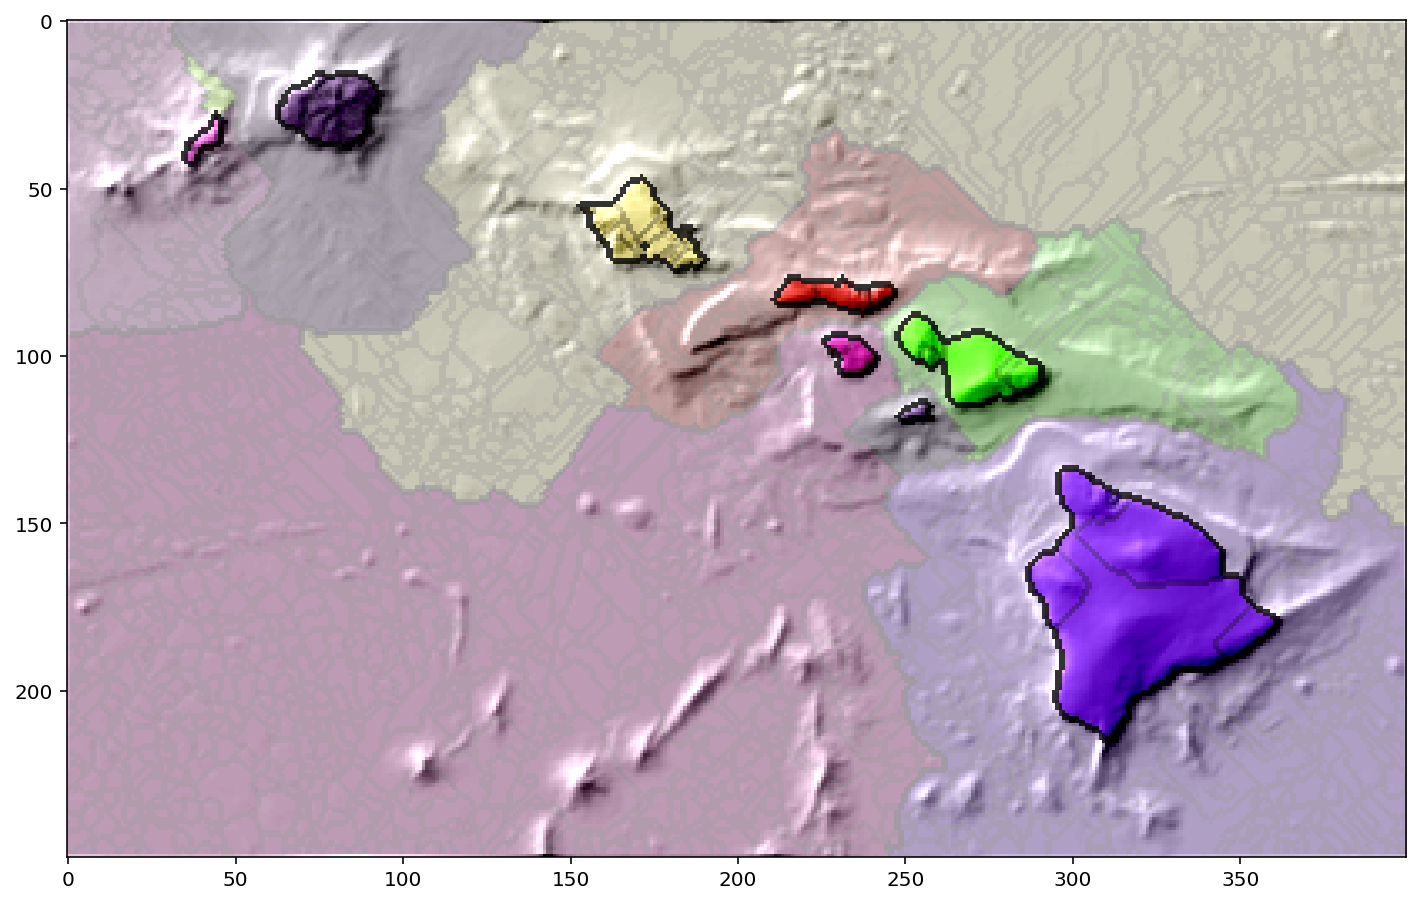

In [13]:
### Separating mountain groups based on the shape of the bridges full ridge line
# Before I was separating mountains into groups if they immediately between islands.
# This changes it and we examining the full ridge as we're constructing the merges in the first place
# Before we merged two far apart islands with LSL merges but also changes of mountains like LSS-SSS-SSL
# By computing where the interfaces are based on the full breadth of the chain when combining two local
#  mountains, we can definitely separate islands

# Using this criteria I think we get by far the best image. I'm really happy with how this looks. 
# You can even see a 9th largest Hawaiian island Lehua in the top left above, north of Ni'ihau.
# The only drawback is how the open ocean floor still gets arbitrarily grouped with the islands
#   but I have a hard time developing a convincing criteria to say what is open ocean floor 
#   and what should be grouped into the islands.
# Perhaps using a cost function like "Don't extend this horizontally if the angle is too shallow" or
#   setting a size limit for groupings. That will be another notebook

_ = drawDivisionsBreakingUpBridgesByInterface(
    params, maps, merges, nodes_path_interface, 
    compare_across_full_path = True,
    interfaces_to_split=['LSL'], display_images = True)

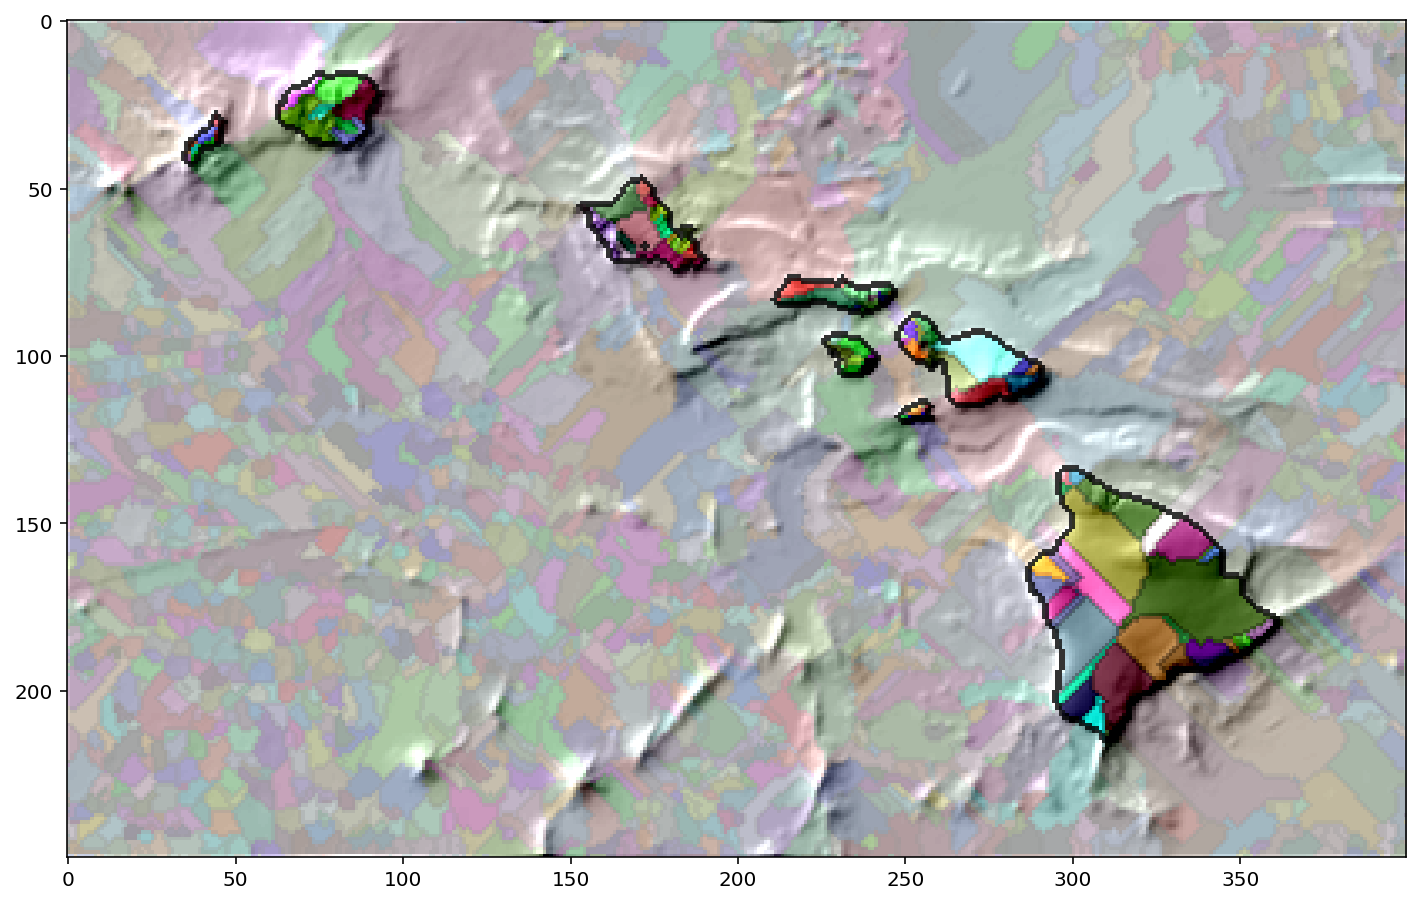

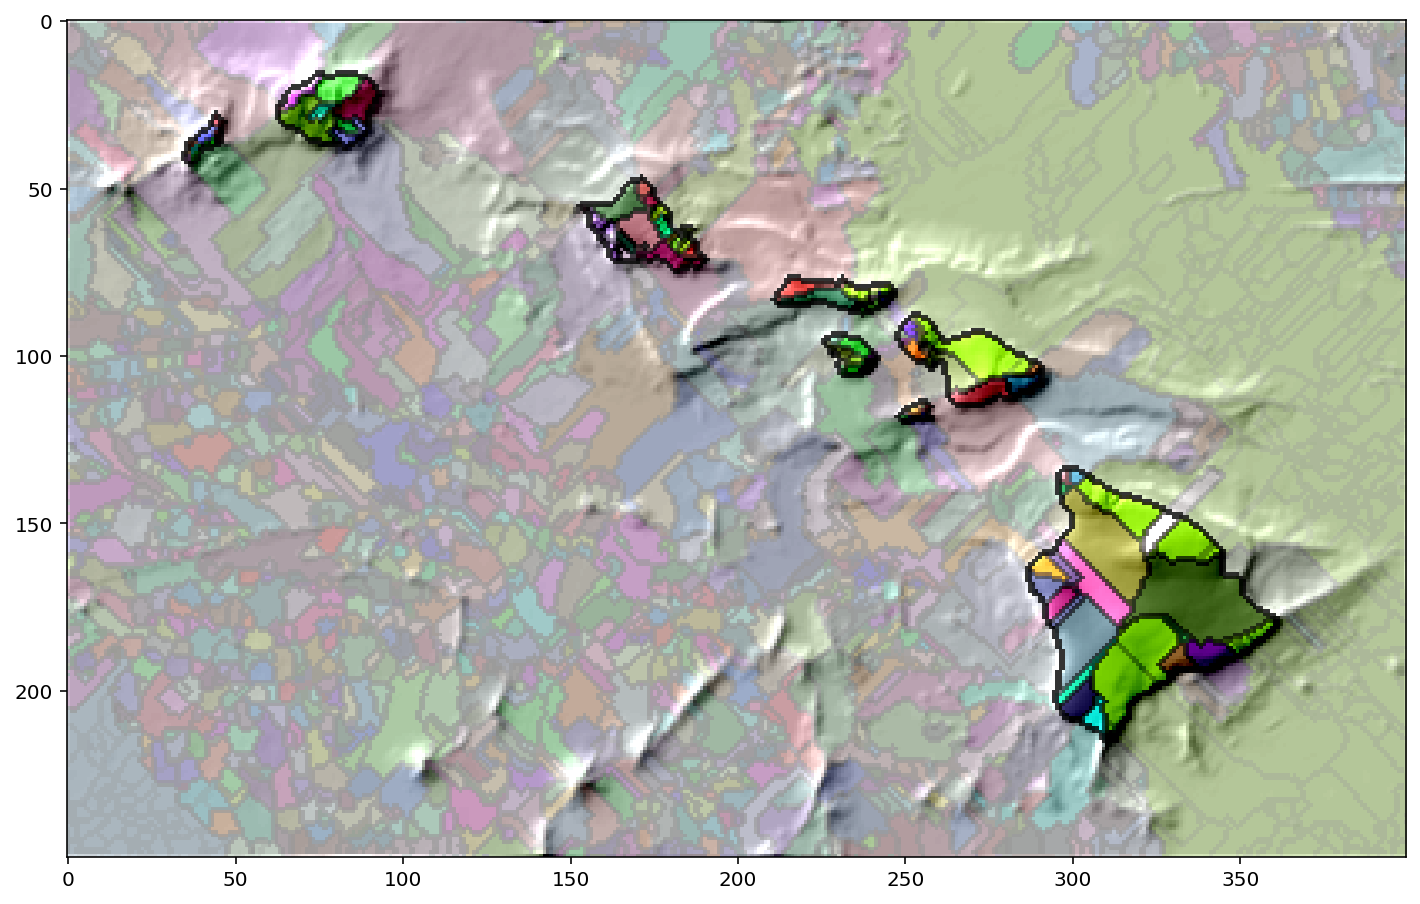

How many things do we have?
    100000 nodes (pixel), points across the map along a 2-dimensional grid
      2052 basins, groupings where all of the nodes in a local area point downward to a single point
               sinks are the lowest point in these basins and are used to index them
      2051 merges, times where two basins are combined, based on the lowest point outward from a basin
               bridges or saddles are the name for the specific points where the merge happens
               rivers are the paths connecting bridges to their sink -- following the lowest local nodes

Let's now think of how basins intersect and are combined along the bridge nodes
Think of the intersections like V shapes. greater sink -> bridge -> lesser sink -- are these Vs large? Are they partially underwater?

Do the rivers in the connections cross the water line / interface? Considering what is above water (L) or below (S)?
Interface Pattern : Local  Divisions
LLL               :   2041   2041
LSL 

In [14]:
# Let's finish off this notebook by generating a bunch of analysis for watershed too
# And also other regions of the map

params = {
    'dataset':'TBI',
    'region': 'hawaii',
    'minutes_per_node': 1,
    'image_folder': 'img/03/',
    'n_neighbors': 4,
    'flow_direction': 'down',
}

params = getLabels(params)
[maps, nodes_neighbors] = generateBaseMaps(params)


merges = getDivisionMergePoints(params, maps, nodes_neighbors)
    
printEarlyDivisionStats(params, merges, maps['locale'].getDataFlat())
    

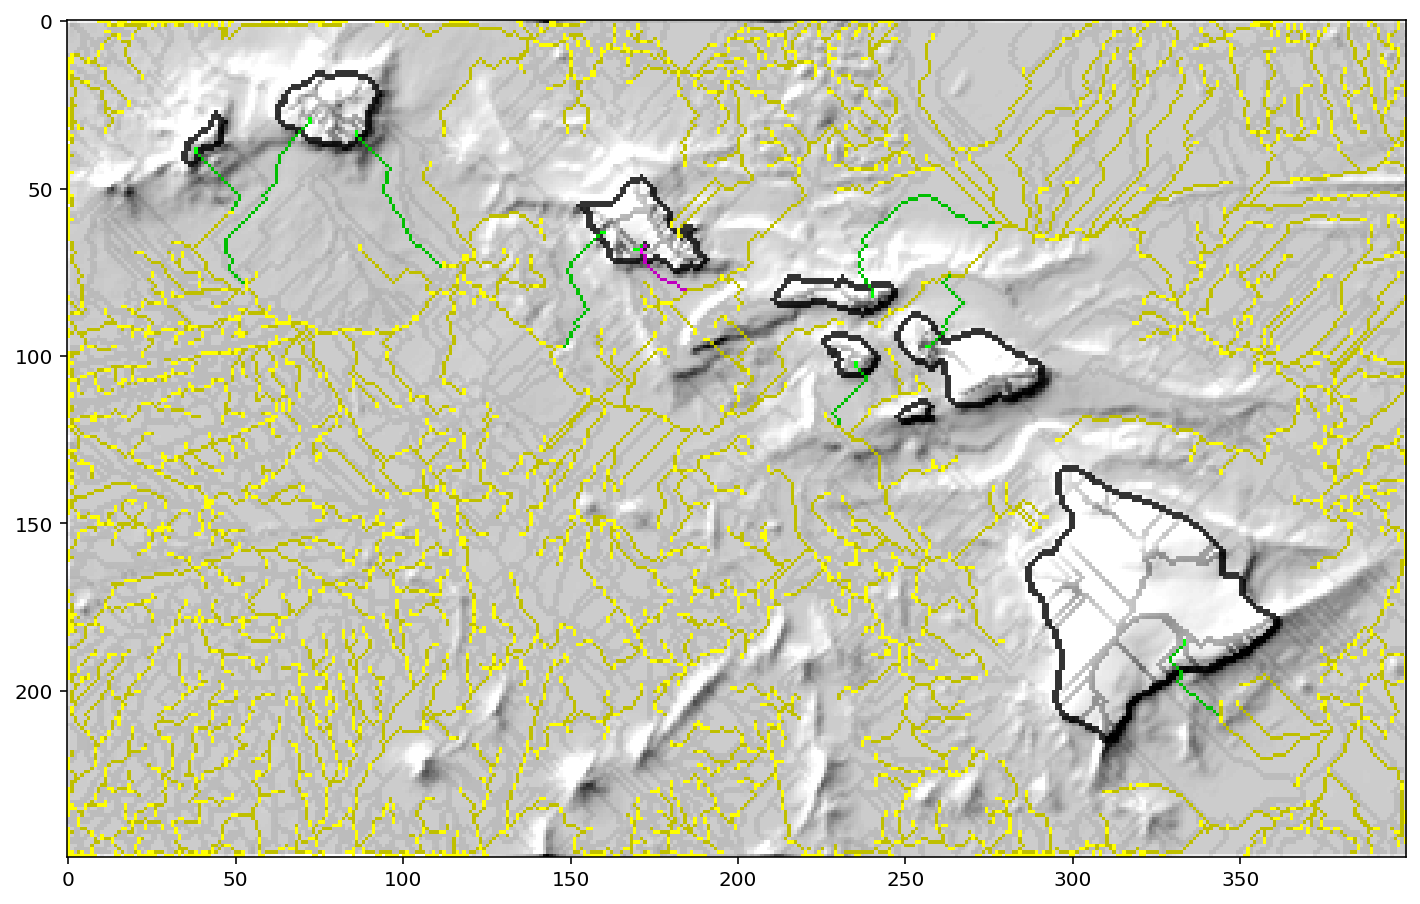

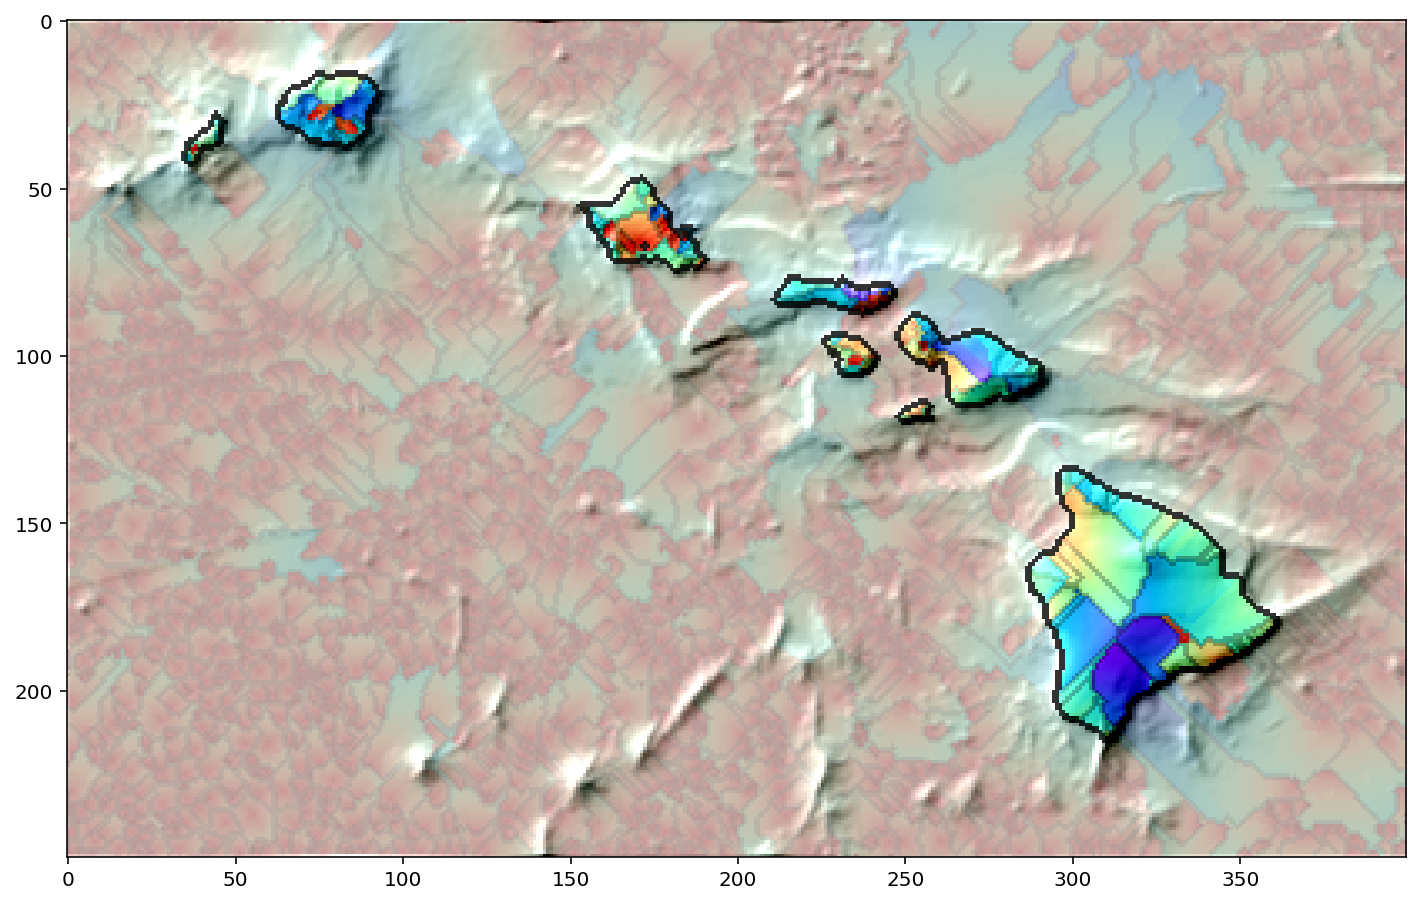

basins with   1 connection :    707
basins with   2 connections:    884
basins with 3-5 connections:    438
basins with  >5 connections:     23



In [15]:
nodes_path = getPaths(params, maps, merges, draw=False)
nodes_path_interface = getPathInterfaceType(params, maps, merges, display_image=True)
renderPathDistanceFromLocalExtremum(params, maps)
locales_adjacency_list = getLocaleAdjacencyList(merges, verbose=True)

tbi_1min_hawaii_watersheds-separating_LSS_merges-compare_across_full_path.png


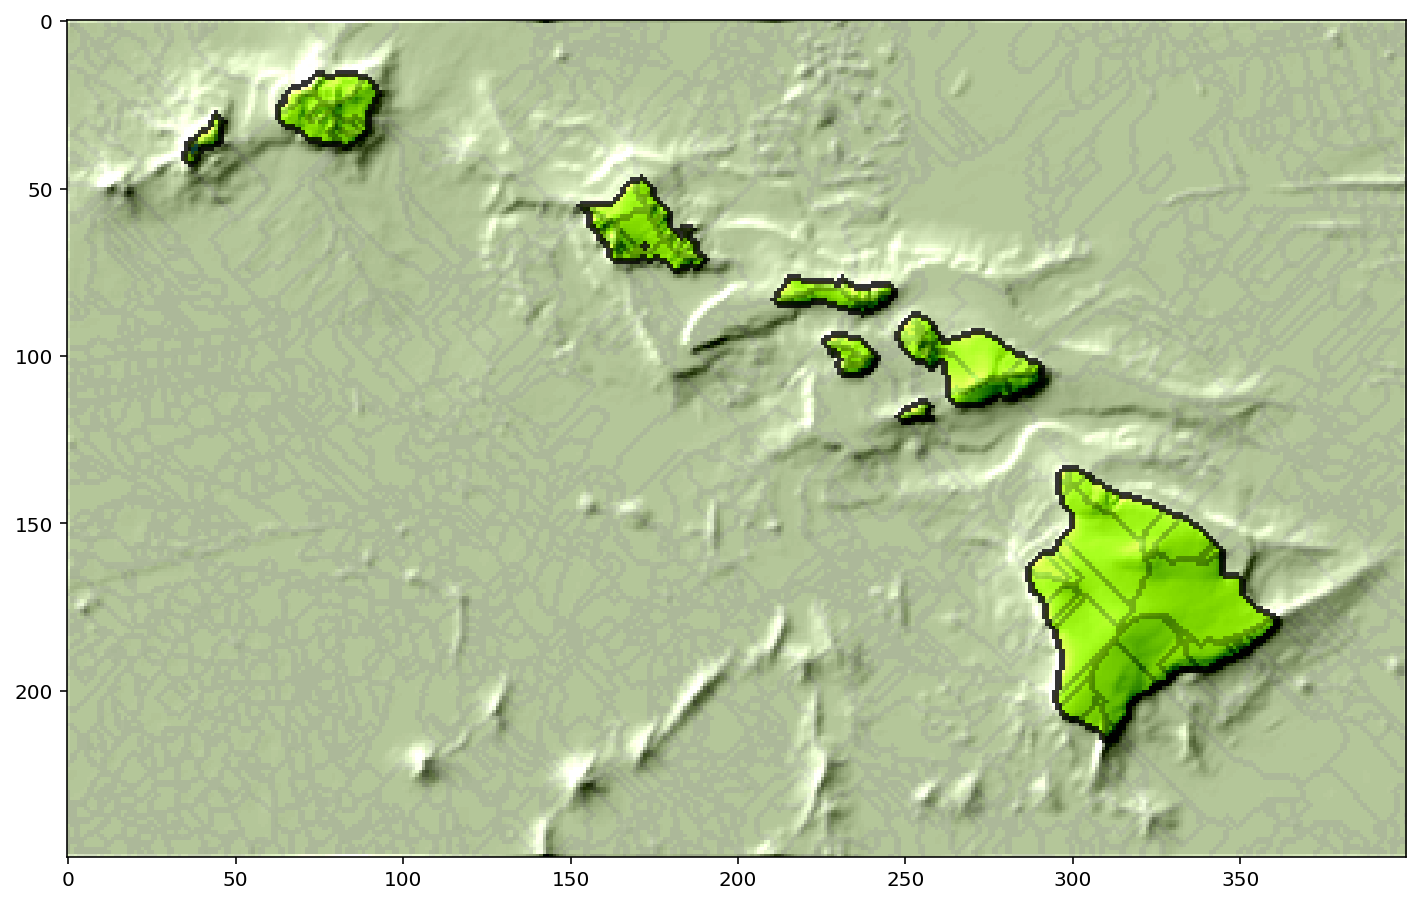

tbi_1min_hawaii_watersheds-separating_LSL_merges-compare_across_full_path.png


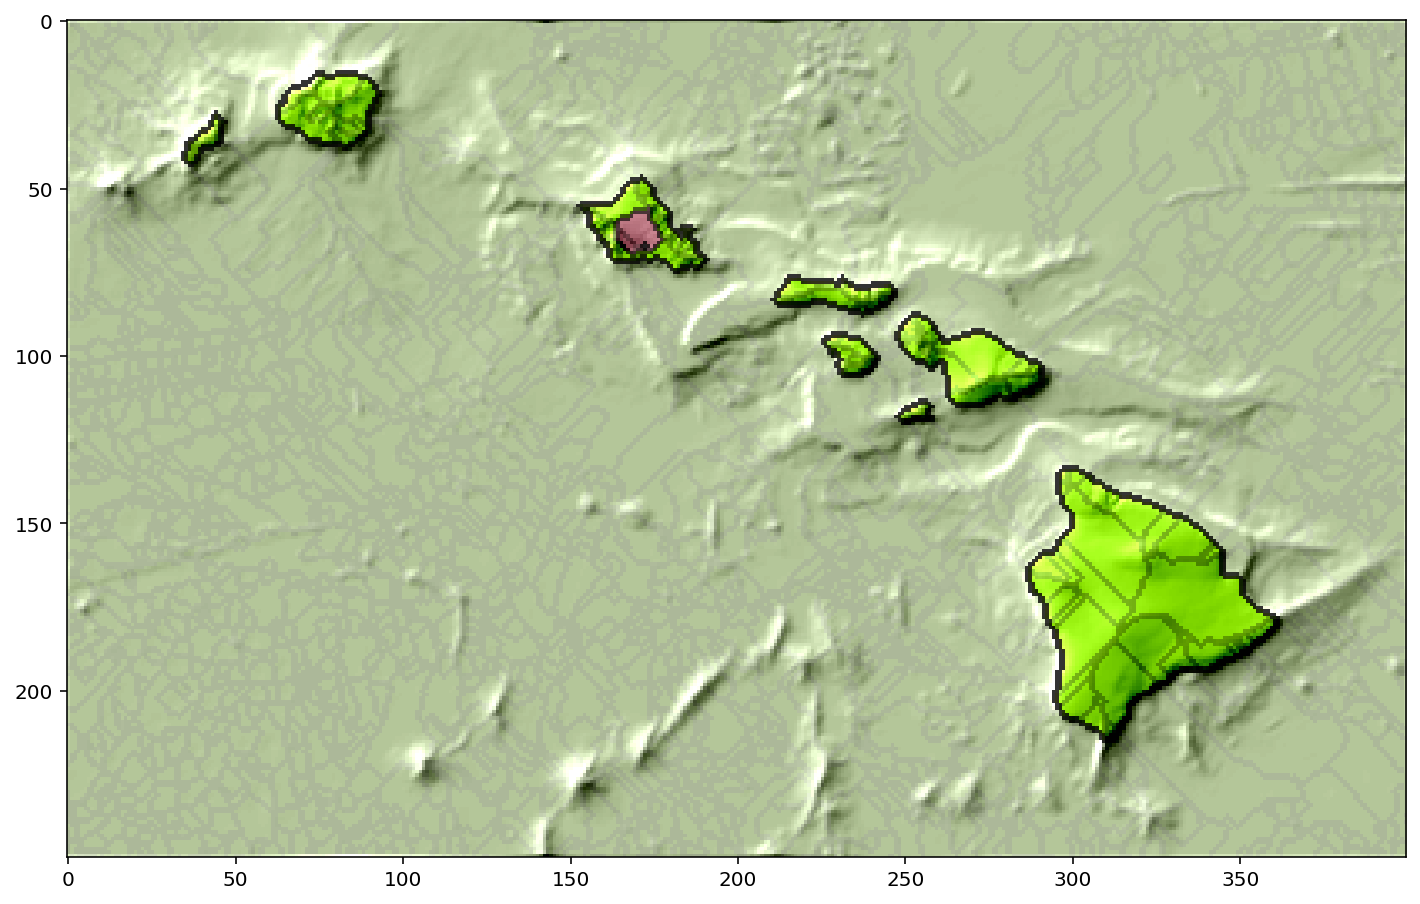

tbi_1min_hawaii_watersheds-separating_LSL+LSS_merges-compare_across_full_path.png


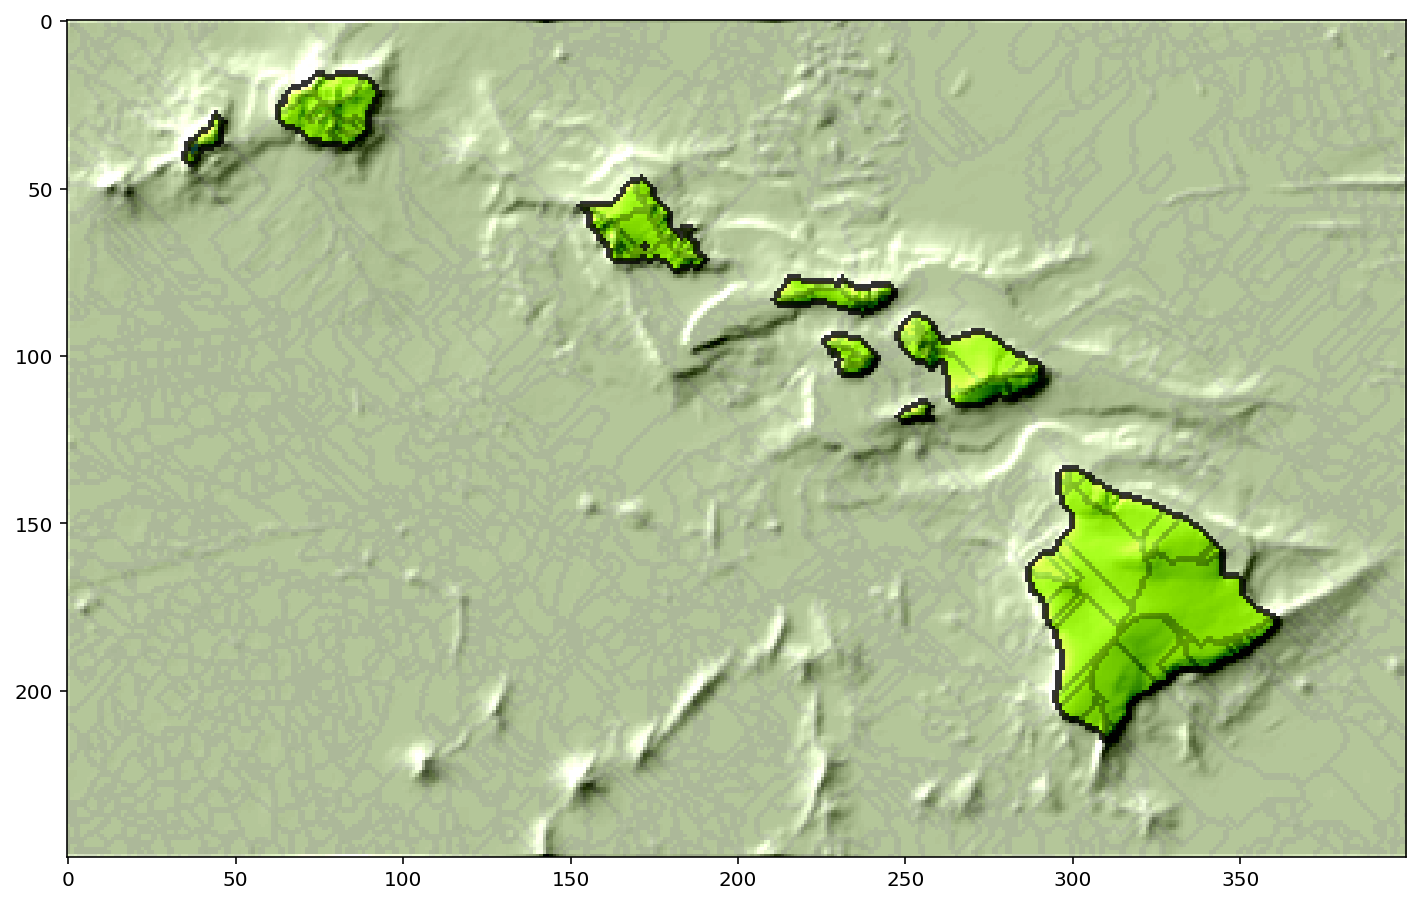

tbi_1min_hawaii_watersheds-separating_LLL_merges-compare_across_full_path.png


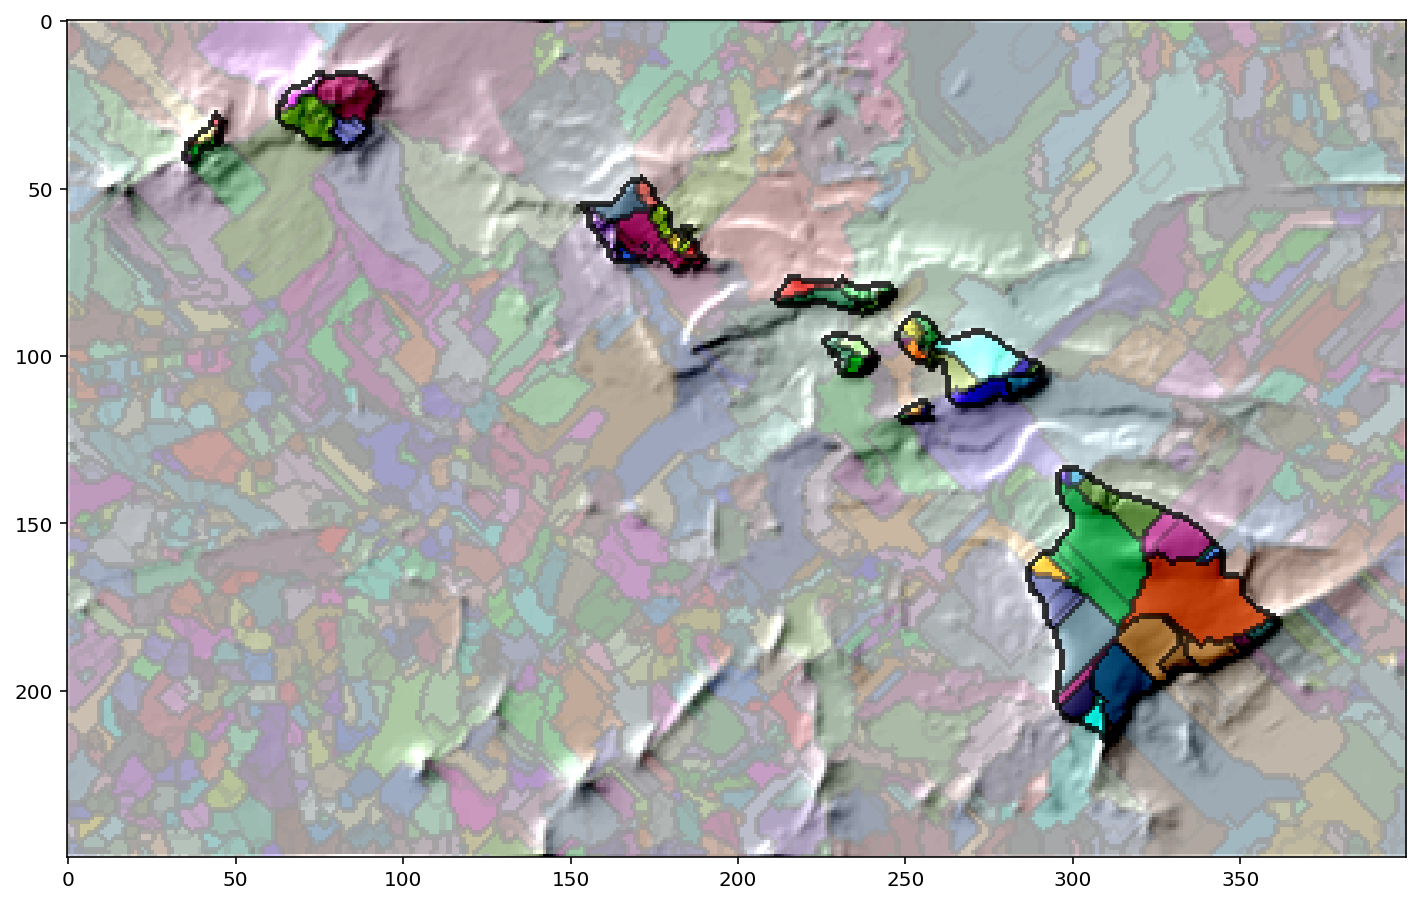

In [16]:

for interfaces_to_split in [
        ['LSS'], # All 1 group
        ['LSL'], # Only Oahu's inner island clearly separated
        ['LSL', 'LSS'],  # All 1 group
        ['LLL'],
    ]:
    _ = drawDivisionsBreakingUpBridgesByInterface(
        params, maps, merges, nodes_path_interface, 
        compare_across_full_path = True,
        interfaces_to_split=interfaces_to_split, display_images = True, print_filenames=True)

### Hawaii Watershed Analysis

Well, this didn't work out that well. The problem is with the splitting criteria -- almost every water shed merges underwater so having an over-water/under-water split doesn't make meaningful differences.

In [17]:
# Let's finish off this notebook by generating a bunch of analysis for watershed too
# And also other regions of the map

def drawWatershedsAndIslandsForRegion(region, minutes_per_node, flow_direction):
    params = {
        'dataset':'TBI',
        'region': region,
        'minutes_per_node': minutes_per_node,
        'image_folder': 'img/03/',
        'n_neighbors': 4,
        'flow_direction': flow_direction,
    }
    params = getLabels(params)

    # Compute locales
    [maps, nodes_neighbors] = generateBaseMaps(params, display_and_save_image=False)

    # Compute merge points between locales
    merges = getDivisionMergePoints(params, maps, nodes_neighbors, draw_and_save_image=False)
    # printEarlyDivisionStats(params, merges, maps['locale'].getDataFlat())

    # Compute paths between locales
    nodes_path = getPaths(params, maps, merges, draw=False)
    nodes_path_interface = getPathInterfaceType(params, maps, merges, display_image=False)
    # renderPathDistanceFromLocalExtremum(params, maps)
    locales_adjacency_list = getLocaleAdjacencyList(merges, verbose=False)

    # Compute divisions divided between sealevel
    interfaces_to_split = ['LSL'] if params['flow_direction'] == 'up' else ['LSS', 'SSL']
    compare_across_full_path = params['flow_direction'] == 'up' 
    _ = drawDivisionsBreakingUpBridgesByInterface(
        params, maps, merges, nodes_path_interface, 
        compare_across_full_path = compare_across_full_path, interfaces_to_split=interfaces_to_split, 
        print_filenames=True, display_images=False, final_analysis_filename=True)
    

In [19]:
# Draw islands and drainage basins for many maps

# # Small enough to run on 1 minute resolution
for region in ['cascadia', 'alps', 'germany', 'korea']:
    drawWatershedsAndIslandsForRegion(region, 1, 'up')
    drawWatershedsAndIslandsForRegion(region, 1, 'down')

# Pushing it in processing speed, but can contrast results at high and low resolutions
for region in ['westus', 'britain', 'italy']:
    drawWatershedsAndIslandsForRegion(region, 5, 'up')
    drawWatershedsAndIslandsForRegion(region, 5, 'down')
    drawWatershedsAndIslandsForRegion(region, 1, 'up')
    drawWatershedsAndIslandsForRegion(region, 1, 'down')
    
# Larger regions where it is interesting to see both basins and islands
for region in ['eastus', 'indonesia', 'eu', 'mesoam', 'eastasia']:
    # The 'emea' region is also pretty interesting but a bit too big (~10 minutes on my laptop) and can be discerned with the eu & middle east regions
    drawWatershedsAndIslandsForRegion(region, 5, 'up')
    drawWatershedsAndIslandsForRegion(region, 5, 'down')
    
# Larger regions where it is interesting to see just drainage basins
for region in ['casia', 'myanmar', 'australia', 'bantu', 'middleeast', 'us', 'india', 'china', 'riftvalley', 'wafrica', 'suram']:
    drawWatershedsAndIslandsForRegion(region, 5, 'down')
    
# Larger regions where it is interesting to see just islands
for region in ['oceania', 'japan']:
    drawWatershedsAndIslandsForRegion(region, 5, 'up')

tbi_5min_britain_islands.png
tbi_5min_britain_drainage_basins.png
tbi_1min_britain_islands.png
tbi_1min_britain_drainage_basins.png
tbi_5min_italy_islands.png
tbi_5min_italy_drainage_basins.png
tbi_1min_italy_islands.png
tbi_1min_italy_drainage_basins.png
tbi_5min_eastus_islands.png
tbi_5min_eastus_drainage_basins.png
tbi_5min_indonesia_islands.png
tbi_5min_indonesia_drainage_basins.png
tbi_5min_eu_islands.png
tbi_5min_eu_drainage_basins.png
tbi_5min_mesoam_islands.png
tbi_5min_mesoam_drainage_basins.png
tbi_5min_eastasia_islands.png
tbi_5min_eastasia_drainage_basins.png
tbi_5min_casia_drainage_basins.png
tbi_5min_myanmar_drainage_basins.png
tbi_5min_australia_drainage_basins.png
tbi_5min_bantu_drainage_basins.png
tbi_5min_middleeast_drainage_basins.png
tbi_5min_us_drainage_basins.png
tbi_5min_india_drainage_basins.png
tbi_5min_china_drainage_basins.png
tbi_5min_riftvalley_drainage_basins.png
tbi_5min_wafrica_drainage_basins.png
tbi_5min_suram_drainage_basins.png
tbi_5min_oceania_islan

## Drainage Basins & Island Analysis

After generating a bunch of images, here's note about some of the great and some of the funny things going on in the images. Check out the image folder with all of the examples.

| Map | Image | Notes |
| --- | --- | --- |
| **Cascadia Drainage Basins** | ![Cascadia drainage basins](img/03/tbi_1min_cascadia_drainage_basins.png) | This worked really well! There is a clear contrast between the smaller drainage basins (Klamath, Douglas, Fraser) and the giant inland drainage into the Columbia River. One thing it got wrong (because it doesn't know) is the Endoheric basin around Nevada where water never reaches the sea. I'd guess if Nevada were to really flood though, it would be captured by the Columbia (probably). |
| **United States Drainage Basins** | ![United States drainage basins](img/03/tbi_5min_us_drainage_basins.png) | While it largely does a good job, there are some funny changes. The Rio Grande isn't that grand, and rather the Colorado river takes a large part of the desert basins in southern US / northern Mexico. The great lakes are pretty silly -- but that's because we don't have the real water line of the great lakes in this map. The Hudson river takes over a lot of the Saint Lawrence river -- an interesting change that could happen if the seaway was blocked by glaciers (maybe it even was like that during the ice age). |
| **Alpine Drainage Basins** | ![Alpine drainage basins](img/03/tbi_1min_alps_drainage_basins.png) | This worked alright -- the Po and Tiber basins are super clear. The top of the map though is merged into 1 big system even though in real life it should split into the Rhone, Rhine, and Danube -- however since this zoom-in doesn't have the outputs for the Rhine and Danube, it just merged them all. Something great with this algorithm that you can see too is that the very small systems that just flow directly into the Adriatic and the Mediterranean are not colored separately (it wouldn't really tell us anything) rather its just grouped with the appropriate sea. |
| **North Central Europe Drainage Basins** | ![north central europe drainage basins](img/03/tbi_1min_germany_drainage_basins.png) | Did did a pretty good job capturing the basins in north-central Europe. The Rhine is almost perfectly captured. Like above the Danube's output is missing so its merged incorrectly with the Vistula. Seeing this I really want to draw the rivers themselves -- but I'll have to wait for a period where I have more time for that. |
| **European Drainage Basins** | ![eu drainage basins](img/03/tbi_5min_eu_drainage_basins.png) | Zoomed out, finally the Rhine and Rhone do the right thing. But the Danube just does not want to work :p here it is skipping Wallachia and just draining into Poland / the Vistula. Although I wonder if it ever was blocked from entering Wallachia and something like this could have happened. There are ssome other inaccuracies but in general most basins are captured pretty well. |
| **Oceania Islands** | ![oceania islands](img/03/tbi_5min_oceania_islands.png) | Here we can see the interesting continuations of islands into the bathmetry of Oceania -- a twisted up and ocean platform-rich place because of plate tectonics. You can see New Zealand's continuation into the plateaus around it. |

In [20]:
# And can we do it for the world?!

drawWatershedsAndIslandsForRegion('world', 10, 'up')
drawWatershedsAndIslandsForRegion('world', 10, 'down')

tbi_10min_world_islands.png
tbi_10min_world_drainage_basins.png


## World Map Analysis

Oh wow! it worked. Definitely took time time though...

On the mountain range (really island) algorithm: It looks like the merges sometimes failed withing continents. Funny enough Europe is its own continent (but with slightly different boundaries) as well the east coast of the United States and some other areas like small parts of China. Perhaps this is caused by the stack overflowing when re-assigning the places to new partial zones. Additionally we see the mid-ocean ridges are assigned as their own islands (probably seeded by hotspot islands like Saint Helena).
![world islands](img/03/tbi_10min_world_islands.png)

For the drainage basin algorithm it captures most drainage basins really well. We see the algorithm fail in some places where the average height of an area make it appear as if a river could not pass (eg. Danube entering Wallachia). Additionally non-ocean lakes aren't properly captured, neither are endoheric basins -- this earth has slightly different physics.
![world drainage basins](img/03/tbi_10min_world_drainage_basins.png)

This was cool! We have some ideas for other algorithms (eg. separate groups with large differences) and I'd like to iterate on the drawings more (add rivers? make them scale in width perhaps...). But I'll follow up in a different notebook.
